In [217]:
# for Spotipy
import spotipy # don't forget to write: pip install spotipy on gitbash or cmd or whatever
import spotipy.oauth2 as oauth2
from spotipy.oauth2 import SpotifyClientCredentials
import json
import sys

# Regular python
import pandas as pd
import numpy as np

# For scraping
import requests # For downloading the website
from bs4 import BeautifulSoup # For parsing the website

# For time
import time # make computer go to sleep
import random  # for random numbers
import datetime as dt



# Graphing
from dfply import *
from plotnine import *

# Modeling
from sklearn.tree import DecisionTreeRegressor # Select a model (right now the model doesn't matter)
from sklearn.model_selection import train_test_split # Train-test split
from sklearn.model_selection import KFold # K-fold Cross validation
import sklearn.preprocessing as pp
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import sklearn.metrics as m
from sklearn.model_selection import cross_validate

In [3]:
# Parse JSON
data = {
    "clientID" : "bc9f3e2fa5994153b808dec97aadb7c8",
    "clientSecret" : "ffb21ad5ba2d486ba533d42aa4091892" 
}
with open('authorization.json', 'w') as outfile:
    json.dump(data, outfile)

In [2]:
# Reading JSON file as a dataframe
# clients = pd.read_json("authorization.json")

# Reading JSON file
# Python Parsing JSON 
with open('authorization.json') as json_file:
    data = json.load(json_file)
data # shows contents of json

{'clientID': 'bc9f3e2fa5994153b808dec97aadb7c8',
 'clientSecret': 'ffb21ad5ba2d486ba533d42aa4091892'}

In [120]:
myURI = "spotify:playlist:4UzXak95ei1TL0VddWOWni"

data = [
    {
        "uri" : "spotify:playlist:4UzXak95ei1TL0VddWOWni",
        "like": True
    },
    {
        "uri" : "spotify:playlist:4Fa86B4AHUbsFDSqfCq3Wo",
        "like" : False
    },
    {
        "uri" : "spotify:artist:7JJFJc0AqAeSKo0MeAmEMe",
        "like" : True
    }
]
with open("testSpotify.json", "w") as outfile:
    json.dump(data, outfile)
    
# Getting my credentials
credentials = json.load(open('authorization.json'))
clientID = credentials['clientID']
clientSecret = credentials['clientSecret']

playlistIndex = 2
# Opening testSpotify json file and reading
# basically, getting the first playlist (Boys Love)
playlists = json.load(open("testSpotify.json"))
playlistURI = playlists[playlistIndex]["uri"]
# like = playlists[playlistIndex]["like"]


# Setting Up Crediential Manager And Token

In [121]:
# Setting up manager and client or something..
clientCredManager = SpotifyClientCredentials(client_id = clientID, client_secret = clientSecret)


credentials = oauth2.SpotifyClientCredentials(
        client_id= clientID,
        client_secret = clientSecret)

token = credentials.get_access_token()
sp = spotipy.Spotify(client_credentials_manager = clientCredManager, auth=token)
#spotify = spotipy.Spotify(auth=token)

<ipython-input-121-7084fb1531e8>:9: DeprecationWarning: You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.


In [122]:
# IDEA: maybe have an artist class or something...
# IDEA: or maybe save in dictionary
# key = artist, value = id


def getTrackID(artist, track):
    '''
    Helper method to get the track id from a given artist and track/song
    
    @param string artist the artist name
    @param string track the song name
    @return 
    
    '''
    query = toQuery(artist = artist, track = track)
#     trackList = sp.search(q = query, type = "track")
    trackID = None
    try:
        trackID = sp.search(q = query, type = "track", limit = 5)["tracks"]["items"][0]["id"]
    except (IndexError):
        print("Oops! Couldn't find ID for song = ", track, " by ", artist)
    return trackID
    


def getArtistID(artist, playlistURI = None):
    '''
    Gets the artist ID.
    First time overloading in Python
    
    @param string artist the artist name
    @param string playlistURI the URI for spotify playlist, if given
    @return int the artist ID from spotify
    '''
    artistID = sp.search(q = artist, type = "artist", limit = 5)["artists"]["items"][0]["id"]    
    return artistID

def toQuery(artist, track):
    '''
    Transforms the artist and track into a query (to later search for trackID)
    
    @param string artist the artist name
    @param string track the track/song name
    @return a Spotify-esque query
    '''
    query = artist + " " + track
    return query


def getAudioFeatures(trackID, track = None):
    '''
    Gets the audio features of a track
    
    @param trackID the track ID
    @param track (optional) the track name
    @return a dictionary of all the audio features
    
    '''
    audioFeature = sp.audio_features(trackID)[0]
    audioFeature.pop("id", None)
    audioFeature.pop("uri", None)
    audioFeature.pop("track_href", None)
    audioFeature.pop("analysis_url", None)
    audioFeature.pop("type", None)
    
    numBars = len(sp.audio_analysis(trackID)["bars"])
    numSections = len(sp.audio_analysis(trackID)["sections"])
    numSegments = len(sp.audio_analysis(trackID)["segments"])
    audioFeature["bars"] = numBars
    audioFeature["numSections"] = numSections
    audioFeature["numSegments"] = numSegments
    
    return audioFeature
    

singer = "Ed Sheeran"
# song = "如何"
song = "Perfect"
trackID = getTrackID(song, singer)
#print(trackID)
#sp.search(q = "top 100 hits UK", type = "track", limit = 5)["tracks"]
#audioFeature = sp.audio_features(trackID)[0]
#artistID = getArtistID(singer)
#artistID
audioFeatures = getAudioFeatures(trackID)
audioFeatures
#len(sp.audio_analysis(trackID)["bars"])

{'danceability': 0.599,
 'energy': 0.448,
 'key': 8,
 'loudness': -6.312,
 'mode': 1,
 'speechiness': 0.0232,
 'acousticness': 0.163,
 'instrumentalness': 0,
 'liveness': 0.106,
 'valence': 0.168,
 'tempo': 95.05,
 'duration_ms': 263400,
 'time_signature': 3,
 'bars': 134,
 'numSections': 12,
 'numSegments': 762}

In [6]:
# IDEA: maybe keep a set of all the artists from UMD...then search up all their songs. 
# TODO: when you read down each artist,
'''
Scraping from UMD
Time period: 2019?
Scrape the data from 2018 up to Dec 2019..
But grab only the new songs. Already know how to do that.
Make sure to spawn new columns called: Title, Artist.
New column: trackID = getTrackID(singer, song)

On Spotify
Then grab the songs that came out in 2018 up to Dec 2019.
Make that into a dataframe.
Spawn new column isHit = 0, full of 0s.
Compare UMD songs with the Spotify.
if the song from Spotipy is in the UMD
the isHit column = 1



train Data: 2019
    isHit: from UMD.
        
    isnotHit: 
test Data: Jan 2020--October 2020 from Spotify? or maybe "2020 new songs" playlist..

grab each artist and look up artist id, then check if the artist is in dictionary. 
If not, key = artist and value = artistID
{Boy Sompob: artistID,
"Ed Sheeran": artistID,
"Billkin": artistID}
So also, the dependent variable y = isHit = True

Define: what does it mean to be a hit? if rank > 80?

Then go on spotipy...
for every artist in the artistDictionary
    Build dataframe

Looking up y = isHit = False
Then, look up all the artist's past songs that came out in the year 2020.
This will include songs who spawned in 2020 but never made it onto the top 100 hits.

ML learning part

testData
See all the new songs of 2020 from this playlist I have found (spotify:playlist:21DNCmLznxWN3CkypQnR8G) 
title = "new Songs 2020"

Check if the song is a hit in 2020 in UK...



'''



"\nScraping from UMD\ngrab each artist and look up artist id, then check if the artist is in dictionary. \nIf not, key = artist and value = artistID\nSo also, the dependent variable y = isHit = True\n\nDefine: what does it mean to be a hit? if rank > 80?\n\nLooking up y = isHit = False\nThen, look up all the artist's past songs that came out in the year 2020.\nThis will include songs who spawned in 2020 but never made it onto the top 100 hits.\n\nML learning part\nSee all the new songs of 2020 from this playlist I have found\n\n\n"

In [56]:
scope = "user-library-read"
playlists = sp.user_playlists("spotify")
while playlists:
    for i, playlist in enumerate(playlists['items']):
        print("%4d %s %s" % (i + 1 + playlists['offset'], playlist['uri'],  playlist['name']))
    if playlists['next']:
        playlists = sp.next(playlists)
    else:
        playlists = None

   1 spotify:playlist:37i9dQZF1DXcBWIGoYBM5M Today's Top Hits
   2 spotify:playlist:37i9dQZF1DX0XUsuxWHRQd RapCaviar
   3 spotify:playlist:37i9dQZF1DX1lVhptIYRda Hot Country
   4 spotify:playlist:37i9dQZF1DX10zKzsJ2jva ¡Viva Latino!
   5 spotify:playlist:37i9dQZF1DX4JAvHpjipBk New Music Friday
   6 spotify:playlist:37i9dQZF1DX4sWSpwq3LiO Peaceful Piano
   7 spotify:playlist:37i9dQZF1DX4SBhb3fqCJd Are & Be
   8 spotify:playlist:37i9dQZF1DWXRqgorJj26U Rock Classics
   9 spotify:playlist:37i9dQZF1DX4dyzvuaRJ0n mint
  10 spotify:playlist:37i9dQZF1DXcF6B6QPhFDv Rock This
  11 spotify:playlist:37i9dQZF1DWXJfnUiYjUKT New Music Friday
  12 spotify:playlist:37i9dQZF1DXcRXFNfZr7Tp just hits
  13 spotify:playlist:37i9dQZF1DX4o1oenSJRJd All Out 00s
  14 spotify:playlist:37i9dQZF1DXbTxeAdrVG2l All Out 90s
  15 spotify:playlist:37i9dQZF1DX4UtSsGT1Sbe All Out 80s
  16 spotify:playlist:37i9dQZF1DWTJ7xPn4vNaz All Out 70s
  17 spotify:playlist:37i9dQZF1DXaKIA8E7WcJj All Out 60s
  18 spotify:playlist:37i

 151 spotify:playlist:37i9dQZF1DX37CqNpZIOOZ This Is Richard Strauss
 152 spotify:playlist:37i9dQZF1DX5ZPNS2aXuN4 This Is Bartók
 153 spotify:playlist:37i9dQZF1DX1tT8vLysk8r This Is Prokofiev
 154 spotify:playlist:37i9dQZF1DWSQeR9oTmnyj This Is: John Williams
 155 spotify:playlist:37i9dQZF1DX5M3XSYkKZCl This Is: Pavarotti
 156 spotify:playlist:37i9dQZF1DXaQQM8OxjxoC This Is Brahms
 157 spotify:playlist:37i9dQZF1DX6Hln2awUHXX This Is Wagner
 158 spotify:playlist:37i9dQZF1DWVTUSNpU0pKJ This Is Satie
 159 spotify:playlist:37i9dQZF1DWZhMbcax6CUd This Is Ravel
 160 spotify:playlist:37i9dQZF1DX30FdZ6jR5Gl This Is Philip Glass
 161 spotify:playlist:37i9dQZF1DWTBNkoD4HmYd This Is Vivaldi
 162 spotify:playlist:37i9dQZF1DX93wmY669mVj This Is Liszt
 163 spotify:playlist:37i9dQZF1DWXnRw5VvmZDb This Is Debussy
 164 spotify:playlist:37i9dQZF1DWY3VlkBR4Jhb This Is Schubert
 165 spotify:playlist:37i9dQZF1DWSL7w3snV7Gw This Is: Glenn Gould
 166 spotify:playlist:37i9dQZF1DX9l01QzlK1Yo This Is: London Sy

 301 spotify:playlist:37i9dQZF1DWWhBhYl3ZMvY This Is Rihanna
 302 spotify:playlist:37i9dQZF1DX8IAL5KfmFJA This is Roxette
 303 spotify:playlist:37i9dQZF1DX86aPVQf2emM This Is Sampha
 304 spotify:playlist:37i9dQZF1DX5WbJFtYTzv7 This Is: Skepta
 305 spotify:playlist:37i9dQZF1DWWUJdr9ahsbf This Is Spice Girls
 306 spotify:playlist:37i9dQZF1DX8yMCqd4JdaS This is Sting
 307 spotify:playlist:37i9dQZF1DX5joH2aOAS4r This Is Take That
 308 spotify:playlist:37i9dQZF1DX9AFOBBZSMWw This Is Stormzy
 309 spotify:playlist:37i9dQZF1DX4UK2Qu9x6KC This Is Tina Turner
 310 spotify:playlist:37i9dQZF1DX4c84KflUhSt This Is Tony Bennett
 311 spotify:playlist:37i9dQZF1DX4cEqBpR9k1C This Is Trentemøller
 312 spotify:playlist:37i9dQZF1DX8kI525v95Yu This Is U2
 313 spotify:playlist:37i9dQZF1DWUHyTgDVMaG1 This Is Van Morrison
 314 spotify:playlist:37i9dQZF1DWYrXu9rm1zUZ This Is Volbeat
 315 spotify:playlist:37i9dQZF1DXbW9wx2hgf03 This is: Wiley
 316 spotify:playlist:37i9dQZF1DX7mMRxgkst0Y This Is The Fall
 317 sp

 451 spotify:playlist:4MLFX9OXy9ncfBlTfei9Ok Nightly Meditations
 452 spotify:playlist:71WgbCkbVXGzAltJTAT6lD (Descent) A Beginning
 453 spotify:playlist:37i9dQZF1DX1s9knjP51Oa Calm Vibes
 454 spotify:playlist:37i9dQZF1DWZhzMp90Opmn Pink Noise
 455 spotify:playlist:37i9dQZF1DX9if5QDLdzCa Ocean Escapes
 456 spotify:playlist:37i9dQZF1DWSW4ppn40bal Sleep Noise
 457 spotify:playlist:37i9dQZF1DWVEt8B7a1H1M Birds in the Forest
 458 spotify:playlist:37i9dQZF1DX7Mv4BQ3Z4nC The Yule Log
 459 spotify:playlist:0jJQDST7bzwAYlN19tFLXw Covered in Country
 460 spotify:playlist:37i9dQZF1DX5FuBDzVtEFX Hawaiian Dreams
 461 spotify:playlist:0mY9BQvlpraYLzg9BfKuVa Traffic Jams
 462 spotify:playlist:2nb7lCySvvf7PNxHUD5oun #JazzAppreciationMonth
 463 spotify:playlist:2f4rXblveCedKdU2adFgC8 Motivation Montage
 464 spotify:playlist:7MsOqrEv1TxiHPDiYlWVLx Sugar & Spice
 465 spotify:playlist:3TymQFosH9UgfP5jV5mPEe Soul Soothers
 466 spotify:playlist:1JuraqRjLX4CmhyvvuXiPF Winding Roads
 467 spotify:playlist:0Na

 601 spotify:playlist:31agQ1yW51tGsDIFZbAZMl XFM JUNE 26
 602 spotify:playlist:1omLAKnMAhhkMSe2IGisUZ The Beach Boys: The Real Best Of...
 603 spotify:playlist:0kfqBZx9obUKiLVDwTqGly boys cast
 604 spotify:playlist:2G5Wlqt6clkHH2KFK2LS5Q Happy Birthday George!
 605 spotify:playlist:6vpXSVefNo73POjhwyiWmu Remembering 2Pac
 606 spotify:playlist:3rMnCpY0WEROlje2b8Bjdn The Hot Sounds of 1926
 607 spotify:playlist:45Cyxm3R3Gpn2upYrjcPbc Happy Birthday Kanye!
 608 spotify:playlist:0dVRyMERU2g9M4tWEfaD5B Mollie King 
 609 spotify:playlist:5Ir6gs0eXKyPj3Qin8uEun Happy Birthday Sir Tom!
 610 spotify:playlist:44uPoVqT6tOn5AphWVnSvu Happy Birthday Prince!
 611 spotify:playlist:66uSq0mmMKat8vPRxsbmhp Happy Birthday Joe Cocker
 612 spotify:playlist:4njfFyb4EgzewhH9kTQuwN Happy Birthday Mollie!
 613 spotify:playlist:2vfyCK7WsXnVeItNwuiFFR Congratulations, Sofia and Daniel
 614 spotify:playlist:5zpAWvvDe0Q8TXjrgInIke Welcome Baby Kimye!
 615 spotify:playlist:52FOMIrumGaNXnwKfrlAVf The Roots of... Vam

 751 spotify:playlist:37i9dQZF1DWTypZHlgEy1G Standards de la Chanson Française
 752 spotify:playlist:37i9dQZF1DX6sa8XjvdJIf This Is New Found Glory
 753 spotify:playlist:37i9dQZF1DX9E92APFiTvV This Is Rush
 754 spotify:playlist:37i9dQZF1DX5kVmFQxhnLW This Is Michael Bublé
 755 spotify:playlist:37i9dQZF1DWVpFvorxSZ6K This Is Leonard Cohen
 756 spotify:playlist:37i9dQZF1DX6KE9M7aTCxK This Is NOFX
 757 spotify:playlist:37i9dQZF1DXdJa941ExayM Punk Unleashed
 758 spotify:playlist:37i9dQZF1DX3LDIBRoaCDQ Classic Punk
 759 spotify:playlist:37i9dQZF1DXa9wYJr1oMFq Pop Punk Powerhouses
 760 spotify:playlist:37i9dQZF1DX3MU5XUozve7 Skatepark Punks
 761 spotify:playlist:37i9dQZF1DX7WJ4yDmRK8R The Essential Ska
 762 spotify:playlist:37i9dQZF1DX0KpeLFwA3tO New Punk Tracks
 763 spotify:playlist:37i9dQZF1DX3YlUroplxjF Crash Course
 764 spotify:playlist:37i9dQZF1DXd6tJtr4qeot Punk Essentials
 765 spotify:playlist:37i9dQZF1DX1zG0qRnyaQ3 Political Punks
 766 spotify:playlist:37i9dQZF1DXb2cYklA89lm Hot Rods

 901 spotify:playlist:37i9dQZF1DWVxpHBekDUXK Coping With Loss
 902 spotify:playlist:37i9dQZF1DX9LT7r8qPxfa Noir
 903 spotify:playlist:37i9dQZF1DX6Oqe1LC2A2s Next Classical
 904 spotify:playlist:37i9dQZF1DWYZW76Iw4Lij Medieval 50: Spotify Picks
 905 spotify:playlist:37i9dQZF1DX8ONeLSIu0Ai Modernism 50: Spotify Picks
 906 spotify:playlist:37i9dQZF1DX1FuwERxHNIM Date Night Classical
 907 spotify:playlist:37i9dQZF1DX5kUFcXez8kt Classical Intimate Dinner
 908 spotify:playlist:37i9dQZF1DXcbK8HZQNxAq Indie Classical: Composed In 21st Century
 909 spotify:playlist:37i9dQZF1DX5hL1aT2vhMb Women of Classical
 910 spotify:playlist:37i9dQZF1DX10uaP8FoDNe Minimalism
 911 spotify:playlist:37i9dQZF1DX5AviTMPF0km Contemporary Chinese Classical
 912 spotify:playlist:37i9dQZF1DWV7cvDzE3MOI This Is Chopin
 913 spotify:playlist:1M2abQkxCwrLjzLGgKWnDP Bellini's Opera
 914 spotify:playlist:37i9dQZF1DWSXyN2w7ILMl Haunting Choral
 915 spotify:playlist:37i9dQZF1DX0CM2xT3aAkN Essence of the Renaissance
 916 spot

1051 spotify:playlist:37i9dQZF1DX8gDIpdqp1XJ Modern Psychedelia
1052 spotify:playlist:37i9dQZF1DX1fmyMdW2PaL Complete Chaos
1053 spotify:playlist:37i9dQZF1DX0IlCGIUGBsA Ultimate Party Classics
1054 spotify:playlist:37i9dQZF1DX44AF5xq04Oh Reggae BBQ
1055 spotify:playlist:37i9dQZF1DXcTieYAg7jq1 Retro Pop
1056 spotify:playlist:37i9dQZF1DWWOGXILUAh53 Fresh Dance Pop
1057 spotify:playlist:37i9dQZF1DX98f0uoU1Pcs Noisy
1058 spotify:playlist:37i9dQZF1DXauOWFg72pbl Beer & Wings
1059 spotify:playlist:37i9dQZF1DXdTCdwCKzXwo Early Alternative
1060 spotify:playlist:37i9dQZF1DX09NvEVpeM77 Born in the USA
1061 spotify:playlist:37i9dQZF1DWZMxqlsEB7BT Chips and Salsa
1062 spotify:playlist:37i9dQZF1DX1MUPbVKMgJE Disco Forever
1063 spotify:playlist:37i9dQZF1DX8XxBtyUnC7B Souvenirs
1064 spotify:playlist:37i9dQZF1DWZgauS5j6pMv Nu-Funk
1065 spotify:playlist:37i9dQZF1DX23YPJntYMnh Funk Rock
1066 spotify:playlist:37i9dQZF1DX4pUKG1kS0Ac Guilty Pleasures
1067 spotify:playlist:2lOMjzyPMlcIvcaWlaF6MB Historic Ven

1201 spotify:playlist:37i9dQZEVXbJPcfkRz0wJ0 Australia Top 50
1202 spotify:playlist:37i9dQZEVXbKM896FDX8L1 Ireland Top 50
1203 spotify:playlist:37i9dQZEVXbKGcyg6TFGx6 Luxembourg Top 50
1204 spotify:playlist:37i9dQZEVXbIQnj7RRhdSX Italy Top 50
1205 spotify:playlist:37i9dQZEVXbN6itCcaL3Tt Poland Top 50
1206 spotify:playlist:37i9dQZEVXbKyJS56d1pgi Portugal Top 50
1207 spotify:playlist:37i9dQZEVXbLwpL8TjsxOG Hong Kong Top 50
1208 spotify:playlist:37i9dQZEVXbJlfUljuZExa Malaysia Top 50
1209 spotify:playlist:37i9dQZEVXbK4gjvS1FjPY Singapore Top 50
1210 spotify:playlist:37i9dQZEVXbLesry2Qw2xS Estonia Top 50
1211 spotify:playlist:37i9dQZEVXbKMzVsSGQ49S Iceland Top 50
1212 spotify:playlist:37i9dQZEVXbMx56Rdq5lwc Lithuania Top 50
1213 spotify:playlist:37i9dQZEVXbJWuzDrTxbKS Latvia Top 50
1214 spotify:playlist:37i9dQZEVXbO3qyFxbkOE1 Mexico Top 50
1215 spotify:playlist:4lCv0oN3gPxoqvXmA3cDjS Top Picks Toplists
1216 spotify:playlist:3xGWOQUB6jgHd4PLVQvbfG Top Picks Pop
1217 spotify:playlist:0q2dbyU

1351 spotify:playlist:37i9dQZF1DWU8quswnFt3c Amplify: Seventeen Takeover
1352 spotify:playlist:37i9dQZF1DWYtQSOiZF6hj Happy Birthday
1353 spotify:playlist:6PzNMpCPMDMo1pOUjNhDUC Kids B-day Party
1354 spotify:playlist:2mADaSxlIcxRDSG9e9vLlh Walk The Dog
1355 spotify:playlist:0uZg7go8TKu5hpv1L6CJ4y Tagga För OS
1356 spotify:playlist:5wPUMOWXlhmk9XmGO4RtKz Commuter Flow (That Fire For Your Aux Cord)
1357 spotify:playlist:37i9dQZF1DWWiDhnQ2IIru 70s Road Trip
1358 spotify:playlist:1cddSHoeIrE3m0i8TqYNbn Annorlunda Kärlekslåtar
1359 spotify:playlist:5Dn14a8hNIhT3NLLjUUBGL Fuck Valentine!
1360 spotify:playlist:1apRF10Iufr0NBBiF1u7E5 Valentine anger
1361 spotify:playlist:7qeSmszUjRBWOwHzlxfEXt Det är så tråkigt och trist utan dig
1362 spotify:playlist:2PMlGn5a2jxukdhCYQyQvG Inget är större än KÄRLEKEN
1363 spotify:playlist:3cC0Hnr7idCemR4JxOh2lI Folk & Rock 200 favoriter
1364 spotify:playlist:24HEIuw8etbkitpDCxZ1dQ The Critics Choice 2012
1365 spotify:playlist:0NYlvGXveeyvhb5G80LPtA EM Fotboll

# Getting All Albums From Artist ID

In [6]:
#playlists = sp.user_playlists("spotify")
# With an artist ID, how to grab all their songs
# Look at the artist: Boy Sompob
artistID = playlistURI.split(":")[2]

artistAlbums = sp.artist_albums(artistID)["items"]
for i, playlist in enumerate(artistAlbums):
    # artist = playlist["artists"][0]["name"]
    print("%4d %s %s" % (i + 1, playlist['uri'],  playlist['name']))
    
# a function
def getAlbums(artistID):
    '''
    Gets a list of albums using an artist ID
    
    @param int artistID the artist ID
    @return list a list of albums from the specified artist
    '''
    albums = []
    artistAlbums = sp.artist_albums(artistID)["items"]
    for i, playlist in enumerate(artistAlbums):
        #artist = playlist["artists"][0]["name"]
        
        albums.append(playlist["name"])
        # A helper print line
        print("%4d %s %s" % (i + 1, playlist['uri'],  playlist['name']))
    return albums

# def getTracks(artistID):
    

def getFeatures(trackID):
    '''
    A helper method to get the audio features of the song
    
    @param int trackID the Spotify ID of the track/song
    @return the audio features
    
    '''
    # A JSON format
    features = sp.audio_features(trackID)

# boySompobAlbums = getAlbums(artistID)
#sp.artist_albums(artistID)["items"]


   1 spotify:album:2282fQEMBPsB90KHB1khTY The Luckiest Boy And The Luckiest Fans (Live)
   2 spotify:album:5eMK5WKI1bOKpThYtvlDIW Why I Love You
   3 spotify:album:4bZQoaw4elqZVMiAdhar9w ครั้งนี้ (เพลงประกอบซีรีส์บังเอิญรัก 2 A Chance to love)
   4 spotify:album:3rzEFOUwsYGDeERFtwp5iB เพื่อนเธอ- Live (From " เพลงประกอบซีรีส์บังเอิญรัก 2)
   5 spotify:album:3NoamIlgkZyCBQwQtkQNbH เพื่อนเธอ (Just Friend?) [From "เพลงประกอบซีรีส์บังเอิญรัก 2"]
   6 spotify:album:6FWiRiHZHFc4WZwhOdcanL หวัง
   7 spotify:album:6jGnrA1561aH510qyfJJRz Jigsaw Heart (English Version)
   8 spotify:album:4X2YdBEVqCUuGF5PufmTyG พบเพื่อจาก...รักเพื่อลา (Live session- From "Until we meet again the series")
   9 spotify:album:5mbrSLnrog1oAt5ZUnlHa9 The Luckiest Boy (Original Soundtrack)
  10 spotify:album:4au75uFCaaeKVzbaMsjNTU โชคดีแค่ไหน (Original Soundtrack)
  11 spotify:album:73Ij4BSutAwc0P8e3LdHwE Until We Meet Again (Ost. Until We Meet Again the Series)
  12 spotify:album:3HHInykbtAwdE859nIyJKd พบเพื่อจาก...รัก

## Getting All Tracks And Track ID From Specified Album URI

In [13]:
sp.artist_top_tracks(artistID)
# Search for Ed Sheeran Songs
results = sp.search(q="Ed Sheeran", limit=10, type = "track")
tracks = sp.album_tracks("3oIFxDIo2fwuk4lwCmFZCx")

for i in range(len(tracks["items"])):
    print(tracks["items"][i]["name"])
    print(tracks["items"][i]["id"])
    #tracks["items"][0]["name"]
#results
#for i, t in enumerate(results['tracks']['items']):
#    print(' ', i, t['name'])
#sp.track(artistID)
tracks["items"]

Beautiful People (feat. Khalid)
70eFcWOvlMObDhURTqT4Fv
South of the Border (feat. Camila Cabello & Cardi B)
4vUmTMuQqjdnvlZmAH61Qk
Cross Me (feat. Chance the Rapper & PnB Rock)
4wuCQX7JvAZLlrcmH4AeZF
Take Me Back to London (feat. Stormzy)
1AI7UPw3fgwAFkvAlZWhE0
Best Part of Me (feat. YEBBA)
0VsGaRXR5WAzpu51unJTis
I Don't Care (with Justin Bieber)
0hVXuCcriWRGvwMV1r5Yn9
Antisocial (with Travis Scott)
1DhRbox3xkceP64k3JeYfW
Remember The Name (feat. Eminem & 50 Cent)
0AtP8EkGPn6SwxKDaUuXec
Feels (feat. Young Thug & J Hus)
1Bdptrvb7nQkq8kCw3siE9
Put It All on Me (feat. Ella Mai)
5T03itPFOPGGkvVPvPiyla
Nothing On You (feat. Paulo Londra & Dave)
2qRN7PWiHRLprw4FpDeI9N
I Don't Want Your Money (feat. H.E.R.)
3FHXUqaUer9o231Je1zxIN
1000 Nights (feat. Meek Mill & A Boogie Wit da Hoodie)
4vIKzWqtn44umal5jXq4wE
Way To Break My Heart (feat. Skrillex)
5d1rmWWF1725tnYjq6rMDB
BLOW (with Chris Stapleton & Bruno Mars)
7hvO2qCwJVZxiyoA7c9i5d


[{'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/6eUKZXaKkcviH0Ku9w2n3V'},
    'href': 'https://api.spotify.com/v1/artists/6eUKZXaKkcviH0Ku9w2n3V',
    'id': '6eUKZXaKkcviH0Ku9w2n3V',
    'name': 'Ed Sheeran',
    'type': 'artist',
    'uri': 'spotify:artist:6eUKZXaKkcviH0Ku9w2n3V'},
   {'external_urls': {'spotify': 'https://open.spotify.com/artist/6LuN9FCkKOj5PcnpouEgny'},
    'href': 'https://api.spotify.com/v1/artists/6LuN9FCkKOj5PcnpouEgny',
    'id': '6LuN9FCkKOj5PcnpouEgny',
    'name': 'Khalid',
    'type': 'artist',
    'uri': 'spotify:artist:6LuN9FCkKOj5PcnpouEgny'}],
  'available_markets': ['AD',
   'AE',
   'AL',
   'AR',
   'AT',
   'AU',
   'BA',
   'BE',
   'BG',
   'BH',
   'BO',
   'BR',
   'BY',
   'CA',
   'CH',
   'CL',
   'CO',
   'CR',
   'CY',
   'CZ',
   'DE',
   'DK',
   'DO',
   'DZ',
   'EC',
   'EE',
   'EG',
   'ES',
   'FI',
   'FR',
   'GB',
   'GR',
   'GT',
   'HK',
   'HN',
   'HR',
   'HU',
   'ID',
   'IE',
   'IL',
   'IN'

## Example

In [9]:
sp.artist_top_tracks(artistID)

{'tracks': [{'album': {'album_type': 'single',
    'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/7JJFJc0AqAeSKo0MeAmEMe'},
      'href': 'https://api.spotify.com/v1/artists/7JJFJc0AqAeSKo0MeAmEMe',
      'id': '7JJFJc0AqAeSKo0MeAmEMe',
      'name': 'Boy Sompob',
      'type': 'artist',
      'uri': 'spotify:artist:7JJFJc0AqAeSKo0MeAmEMe'}],
    'external_urls': {'spotify': 'https://open.spotify.com/album/3HHInykbtAwdE859nIyJKd'},
    'href': 'https://api.spotify.com/v1/albums/3HHInykbtAwdE859nIyJKd',
    'id': '3HHInykbtAwdE859nIyJKd',
    'images': [{'height': 640,
      'url': 'https://i.scdn.co/image/ab67616d0000b27381d72a57985aa727ed9ce60f',
      'width': 640},
     {'height': 300,
      'url': 'https://i.scdn.co/image/ab67616d00001e0281d72a57985aa727ed9ce60f',
      'width': 300},
     {'height': 64,
      'url': 'https://i.scdn.co/image/ab67616d0000485181d72a57985aa727ed9ce60f',
      'width': 64}],
    'name': 'พบเพื่อจาก...รักเพื่อลา (Ost. Until W

## Grab Songs From Each Album (By Album ID/URI)

In [123]:
def getTracks(albumURI, artistUri):
    '''
    Gets all the tracks from a specific album using album URI
    
    @param string albumURI the uri of the album
    @return list a list of albums
    
    '''
    # Spawn an empty dictionary for each new albumURI
    albums = {}

    #Create keys-values of empty lists inside nested dictionary for album
    # so we have keys: album, track_number, id, name, uri
    albums['album'] = [] #create empty list
    albumName = sp.album(albumURI)["name"]
    albums["artist"] = []
    albumArtist = sp.artist_albums(artistUri, album_type='album')["items"][0]["artists"][0]["name"]
    
    albums['trackNumber'] = []
    albums['id'] = []
    albums['name'] = []
    albums['uri'] = []
    

    tracks = sp.album_tracks(albumURI) #pull data on album tracks
    # wow tracks is a mess...
    # For every album
    for i in range(len(tracks['items'])): #for each song track
        #print("i = " + str(i) + " " + albumNames[i])

        albums['album'].append(albumName) #append album name tracked via album_count
        albums["artist"].append(albumArtist)
        # Added track number
        albums['trackNumber'].append(tracks['items'][i]['track_number'])

        # Added ID
        albums['id'].append(tracks['items'][i]['id'])

        # Added the track name
        albums['name'].append(tracks['items'][i]['name'])

        # Added track URI
        albums['uri'].append(tracks['items'][i]['uri'])
    return albums

#albumURI = 'spotify:album:6DpIyaMgt5p9HlGd1c0LDM'
#albums = getTracks(albumURI)        
#albums
#print(albums[albumURI])


# albumURI = 'spotify:album:6DpIyaMgt5p9HlGd1c0LDM'
#albums[albumURI] = getTracks('spotify:album:6DpIyaMgt5p9HlGd1c0LDM')
# albums[albumURI]


# albums = {}
# # album_count = 0
# for URI in albumURIs:
# #     #print("URI  = " + URI)
#     albums[URI] = getTracks(URI)
#     print("Album " + str(albumNames[album_count]) + " songs has been added to spotify_albums dictionary")
#     album_count += 1 #Updates album count once all tracks have been added

In [71]:
for i in range(len(tracks["items"][0]["artists"])):
    print(tracks["items"][0]["artists"][i]["name"])

Ed Sheeran
Khalid


In [8]:
def getAudioFeatures(albumURI, albums):
    #Add new key-values to store audio features
    #albums = {}
    albums[albumURI]['acousticness'] = []
    albums[albumURI]['danceability'] = []
    albums[albumURI]['duration_ms'] = []
    albums[albumURI]['energy'] = []
    albums[albumURI]["explicit"] = []
    albums[albumURI]['instrumentalness'] = []
    albums[albumURI]['key'] = []
    albums[albumURI]['liveness'] = []
    albums[albumURI]['loudness'] = []
    albums[albumURI]['mode'] = []
    albums[albumURI]['speechiness'] = []
    albums[albumURI]['tempo'] = []
    albums[albumURI]['timeSignature'] = []
    albums[albumURI]['valence'] = []
    albums[albumURI]['popularity'] = []
    
    
    
    
    
    #create a track counter
    track_count = 0
    
    for track in albums[albumURI]['uri']:
        #pull audio features per track
        features = sp.audio_features(track)[0]
        #Append to relevant key-value
        albums[albumURI]['acousticness'].append(features['acousticness'])
        albums[albumURI]['danceability'].append(features['danceability'])
        albums[albumURI]["duration_ms"].append(features["duration_ms"])
        albums[albumURI]['energy'].append(features['energy'])
        albums[albumURI]['instrumentalness'].append(features['instrumentalness'])
        albums[albumURI]["key"].append(features["key"])
        albums[albumURI]['liveness'].append(features['liveness'])
        albums[albumURI]['loudness'].append(features['loudness'])
        albums[albumURI]["mode"].append(features["mode"])
        albums[albumURI]['speechiness'].append(features['speechiness'])
        albums[albumURI]['tempo'].append(features['tempo'])
        albums[albumURI]["timeSignature"].append(features["time_signature"])
        albums[albumURI]['valence'].append(features['valence'])
        
        
        
        
        #popularity is stored elsewhere
        pop = sp.track(track)
        albums[albumURI]['popularity'].append(pop['popularity'])
        
        # Add whether it is explicit
        albums[albumURI]["explicit"].append(pop["explicit"])
        track_count+=1
    return albums




In [17]:

# For the artist Ed Sheeran
artists = {"Ed Sheeran", "Boy Sompob", "Billkin", "Cardi B"}
sleep_min = 2
sleep_max = 5
df = pd.DataFrame()
for artist in artists:
    
    result = sp.search(artist) #search query


    #Extract Artist's uri
    artistUri = result['tracks']['items'][0]['artists'][0]['uri']
#Pull all of the artist's albums

# Grab the albums dictionary
    albums = sp.artist_albums(artistUri, album_type='album')

# Store artist's albums' names' and uris in separate lists
    albumNames = []
    albumURIs = []

    for i in range(len(albums['items'])):
        albumNames.append(albums['items'][i]['name'])
        albumURIs.append(albums['items'][i]['uri'])
    
    albums = {}
# album_count = 0
    requestCount = 0
    for URI in albumURIs:
#     #print("URI  = " + URI)
        albums[URI] = getTracks(URI, artistUri)
        albums = getAudioFeatures(URI, albums)
        requestCount += 1
    
        if requestCount % 5 == 0:
            time.sleep(np.random.uniform(sleep_min, sleep_max))
    dic_df = {}
    dic_df['album'] = []
    dic_df["artist"] = []
    dic_df['trackNumber'] = []
    dic_df['id'] = []
    dic_df['name'] = []
    dic_df['uri'] = []
    dic_df['acousticness'] = []
    dic_df['danceability'] = []
    dic_df["duration_ms"] = []
    dic_df['energy'] = []
    dic_df["explicit"] = []
    dic_df['instrumentalness'] = []
    dic_df["key"] = []
    dic_df['liveness'] = []
    dic_df['loudness'] = []
    dic_df["mode"] = []
    dic_df['speechiness'] = []
    dic_df['tempo'] = []
    dic_df["timeSignature"] = []
    dic_df['valence'] = []
    dic_df['popularity'] = []
    # for every album
    for albumURI in albums: 
        # for every feature in each album
        for feature in albums[albumURI]:
            dic_df[feature].extend(albums[albumURI][feature])
    df1 = pd.DataFrame.from_dict(dic_df)
    df = pd.concat([df,df1], ignore_index=True)
    

    
    # for every URI in all the Ed Sheeran Albums
    #for URI in albums:

#         albums = getAudioFeatures(URI, albums)
#         requestCount += 1
    
#     if requestCount % 5 == 0:
#         time.sleep(np.random.uniform(sleep_min, sleep_max))
#albums
print(len(df))


# Sorting by popularity, then drops duplicates by name
final_df = df.sort_values('popularity', ascending=False).drop_duplicates('name').sort_index()
#df.sort_values('popularity', ascending=False).drop_duplicates('uri').sort_index()
print(len(final_df))
#final_df.to_csv("albums.csv")
# for instance, albumNames[3] = (Deluxe)
# and albumURIs[3] = whatever album URI Deluxe is
#Keep names and uris in same order to keep track of duplicate albums

360
165


In [21]:
final_df.columns

Index(['album', 'artist', 'trackNumber', 'id', 'name', 'uri', 'acousticness',
       'danceability', 'duration_ms', 'energy', 'explicit', 'instrumentalness',
       'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo',
       'timeSignature', 'valence', 'popularity'],
      dtype='object')

In [48]:
final_df.head()

,album,artist,trackNumber,id,name,uri,acousticness,danceability,duration_ms,energy,...,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,timeSignature,valence,popularity
0,No.6 Collaborations Project,Ed Sheeran,1.0,70eFcWOvlMObDhURTqT4Fv,Beautiful People (feat. Khalid),spotify:track:70eFcWOvlMObDhURTqT4Fv,0.124,0.640,197867.0,0.647,...,0.000000,5.0,0.0801,-8.114,0.0,0.1860,92.979,4.0,0.546,77.0
1,No.6 Collaborations Project,Ed Sheeran,2.0,4vUmTMuQqjdnvlZmAH61Qk,South of the Border (feat. Camila Cabello & Ca...,spotify:track:4vUmTMuQqjdnvlZmAH61Qk,0.148,0.857,204467.0,0.621,...,0.000000,9.0,0.0865,-6.376,0.0,0.0825,97.989,4.0,0.668,81.0
2,No.6 Collaborations Project,Ed Sheeran,3.0,4wuCQX7JvAZLlrcmH4AeZF,Cross Me (feat. Chance the Rapper & PnB Rock),spotify:track:4wuCQX7JvAZLlrcmH4AeZF,0.212,0.746,206187.0,0.787,...,0.000000,4.0,0.0669,-6.373,1.0,0.1200,95.005,4.0,0.607,65.0
3,No.6 Collaborations Project,Ed Sheeran,4.0,1AI7UPw3fgwAFkvAlZWhE0,Take Me Back to London (feat. Stormzy),spotify:track:1AI7UPw3fgwAFkvAlZWhE0,0.219,0.885,189733.0,0.762,...,0.000000,8.0,0.1620,-5.513,0.0,0.2160,138.058,4.0,0.605,71.0
4,No.6 Collaborations Project,Ed Sheeran,5.0,0VsGaRXR5WAzpu51unJTis,Best Part of Me (feat. YEBBA),spotify:track:0VsGaRXR5WAzpu51unJTis,0.758,0.565,243267.0,0.243,...,0.000009,2.0,0.2850,-8.367,1.0,0.0317,81.655,4.0,0.239,69.0


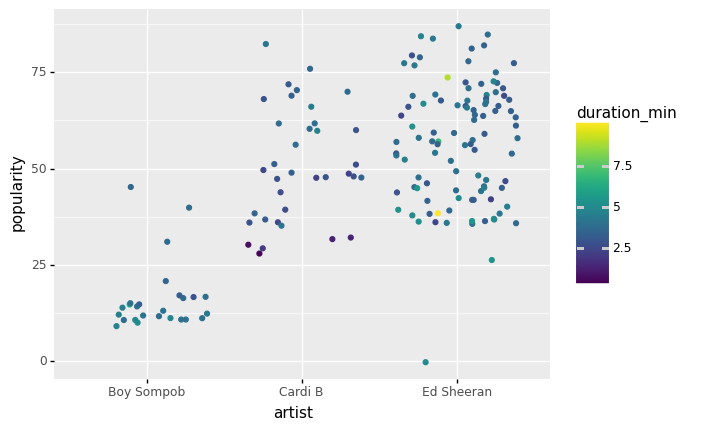

<ggplot: (110086891960)>

In [33]:
(
    final_df >>
    group_by(X.artist) >>
    mutate(duration_min = X.duration_ms/(1000 * 60)) >>
    ggplot() +
    geom_point(aes(x = "artist", y = "popularity", color = "duration_min"), position = "jitter")
)

## Adding This Data Into Dataframe

In [164]:
dic_df = {}
dic_df['album'] = []
dic_df["artist"] = []
dic_df['trackNumber'] = []
dic_df['id'] = []
dic_df['name'] = []
dic_df['uri'] = []
dic_df['acousticness'] = []
dic_df['danceability'] = []
dic_df["duration_ms"] = []
dic_df['energy'] = []
dic_df['instrumentalness'] = []
dic_df["key"] = []
dic_df['liveness'] = []
dic_df['loudness'] = []
dic_df["mode"] = []
dic_df['speechiness'] = []
dic_df['tempo'] = []
dic_df["timeSignature"] = []
dic_df['valence'] = []
dic_df['popularity'] = []
for albumURI in albums: 
    for feature in albums[albumURI]:
        dic_df[feature].extend(albums[albumURI][feature])
df = pd.DataFrame.from_dict(dic_df)
df

,album,artist,trackNumber,id,name,uri,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,timeSignature,valence,popularity
0,The Luckiest Boy And The Luckiest Fans (Live),Ed Sheeran,1,3JVLKqscpTZC0KjPTIp7Ki,Introduction + Nanana - Live,spotify:track:3JVLKqscpTZC0KjPTIp7Ki,0.3630,0.428,371516,0.4540,0.000281,5,0.3730,-13.504,1,0.0453,104.816,4,0.305,15
1,The Luckiest Boy And The Luckiest Fans (Live),Ed Sheeran,2,2vnwvaCorpIdxzi790ytAx,สั่น - Live,spotify:track:2vnwvaCorpIdxzi790ytAx,0.6340,0.310,272000,0.4500,0.000128,11,0.8320,-14.203,1,0.0842,208.051,4,0.556,14
2,The Luckiest Boy And The Luckiest Fans (Live),Ed Sheeran,3,382yPnw2naMUF3OilwY5I5,พระอาทิตย์เที่ยงคืน - Live,spotify:track:382yPnw2naMUF3OilwY5I5,0.3340,0.571,258000,0.5090,0.000005,0,0.1480,-12.779,1,0.0541,120.564,4,0.346,13
3,The Luckiest Boy And The Luckiest Fans (Live),Ed Sheeran,4,5oLIk8lbI7zAZd60920Fvl,ถ้าหากรักมีจริง - Live,spotify:track:5oLIk8lbI7zAZd60920Fvl,0.5790,0.514,236500,0.4680,0.300000,2,0.2360,-15.632,1,0.0435,93.058,4,0.596,11
4,The Luckiest Boy And The Luckiest Fans (Live),Ed Sheeran,5,079JaaFsC78SRsHaQwheYg,รักฉัน...ไม่มีวันเปลี่ยน - Live,spotify:track:079JaaFsC78SRsHaQwheYg,0.3930,0.544,273435,0.4650,0.000001,2,0.2160,-14.060,1,0.0377,95.647,4,0.632,12
5,The Luckiest Boy And The Luckiest Fans (Live),Ed Sheeran,6,5GvKct9twDFZDJnUeWwRFk,Jigsaw Heart - Live,spotify:track:5GvKct9twDFZDJnUeWwRFk,0.2440,0.463,248172,0.2260,0.000033,5,0.3680,-15.222,1,0.0339,92.664,4,0.364,12
6,The Luckiest Boy And The Luckiest Fans (Live),Ed Sheeran,7,0fsdwMcNWPIW0HGD49sGjI,รักไม่ได้ - Live,spotify:track:0fsdwMcNWPIW0HGD49sGjI,0.7770,0.367,300500,0.0504,0.000027,5,0.1840,-19.649,1,0.0410,177.286,3,0.213,10
7,The Luckiest Boy And The Luckiest Fans (Live),Ed Sheeran,8,1KbKQIbDKYD6HDdmE9kLji,เรื่องจริงกับความฝัน - Live,spotify:track:1KbKQIbDKYD6HDdmE9kLji,0.5940,0.359,238000,0.1320,0.000027,0,0.4050,-17.473,1,0.0486,77.693,4,0.300,11
8,The Luckiest Boy And The Luckiest Fans (Live),Ed Sheeran,1,4c1GnBAZcGeChFIGAWavF0,ย้อน - Live,spotify:track:4c1GnBAZcGeChFIGAWavF0,0.6480,0.510,296000,0.1620,0.000000,9,0.1790,-15.676,1,0.0397,136.775,3,0.284,11
9,The Luckiest Boy And The Luckiest Fans (Live),Ed Sheeran,2,2odAd626HMTHYOnChqml7R,ขอ - Live,spotify:track:2odAd626HMTHYOnChqml7R,0.5900,0.633,232000,0.4910,0.000040,9,0.7800,-14.158,1,0.0807,110.039,4,0.531,12


## Eradicating Duplicates

In [74]:
print(len(df))
# Sorting by popularity, then drops duplicates by name
final_df = df.sort_values('popularity', ascending=False).drop_duplicates('name').sort_index()
#df.sort_values('popularity', ascending=False).drop_duplicates('uri').sort_index()
print(len(final_df))
#final_df.to_csv("albums.csv")

360
165


In [242]:
final_df

,album,artist,trackNumber,id,name,uri,acousticness,danceability,duration_ms,energy,...,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,timeSignature,valence,popularity
0,No.6 Collaborations Project,Ed Sheeran,1.0,70eFcWOvlMObDhURTqT4Fv,Beautiful People (feat. Khalid),spotify:track:70eFcWOvlMObDhURTqT4Fv,0.12400,0.640,197867.0,0.647,...,0.000000,5.0,0.0801,-8.114,0.0,0.1860,92.979,4.0,0.546,77.0
1,No.6 Collaborations Project,Ed Sheeran,2.0,4vUmTMuQqjdnvlZmAH61Qk,South of the Border (feat. Camila Cabello & Ca...,spotify:track:4vUmTMuQqjdnvlZmAH61Qk,0.14800,0.857,204467.0,0.621,...,0.000000,9.0,0.0865,-6.376,0.0,0.0825,97.989,4.0,0.668,81.0
2,No.6 Collaborations Project,Ed Sheeran,3.0,4wuCQX7JvAZLlrcmH4AeZF,Cross Me (feat. Chance the Rapper & PnB Rock),spotify:track:4wuCQX7JvAZLlrcmH4AeZF,0.21200,0.746,206187.0,0.787,...,0.000000,4.0,0.0669,-6.373,1.0,0.1200,95.005,4.0,0.607,65.0
3,No.6 Collaborations Project,Ed Sheeran,4.0,1AI7UPw3fgwAFkvAlZWhE0,Take Me Back to London (feat. Stormzy),spotify:track:1AI7UPw3fgwAFkvAlZWhE0,0.21900,0.885,189733.0,0.762,...,0.000000,8.0,0.1620,-5.513,0.0,0.2160,138.058,4.0,0.605,71.0
4,No.6 Collaborations Project,Ed Sheeran,5.0,0VsGaRXR5WAzpu51unJTis,Best Part of Me (feat. YEBBA),spotify:track:0VsGaRXR5WAzpu51unJTis,0.75800,0.565,243267.0,0.243,...,0.000009,2.0,0.2850,-8.367,1.0,0.0317,81.655,4.0,0.239,69.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,Gangsta Bitch Music Vol 1,Cardi B,9.0,0QOHLcr82xiHHCFXJEZoSb,Trick (Skit) (feat. Haitian V),spotify:track:0QOHLcr82xiHHCFXJEZoSb,0.80500,0.711,127608.0,0.266,...,0.000000,6.0,0.0690,-15.928,0.0,0.8710,128.197,5.0,0.225,29.0
356,Gangsta Bitch Music Vol 1,Cardi B,10.0,0O5WTYTLlTVeInQUDOJJnU,Trick,spotify:track:0O5WTYTLlTVeInQUDOJJnU,0.00816,0.707,172251.0,0.688,...,0.000000,11.0,0.0865,-6.261,0.0,0.2590,93.037,4.0,0.285,36.0
357,Gangsta Bitch Music Vol 1,Cardi B,11.0,0kfumbp5lPQvPrMTrqsaNv,Lit Thot,spotify:track:0kfumbp5lPQvPrMTrqsaNv,0.11700,0.894,181290.0,0.362,...,0.000000,2.0,0.0737,-11.381,1.0,0.4650,139.953,4.0,0.260,48.0
358,Gangsta Bitch Music Vol 1,Cardi B,12.0,5W8U3zV3xjeZL0gjKapWxZ,Sauce Boyz,spotify:track:5W8U3zV3xjeZL0gjKapWxZ,0.15200,0.863,173793.0,0.491,...,0.000000,1.0,0.1330,-8.510,1.0,0.2590,132.968,4.0,0.370,48.0


# Scraping Website

In [124]:
def getDF(url):
    '''
    Gets the dataframe (data table) from a given url
    @param url the specified url
    @return the data frame
    '''
    page = requests.get(url)

    if page.status_code == 200:
        table = pd.read_html(page.text)
        table = table[9]
        # Drop the first 2 "rows"
        table.drop([0, 1], inplace = True)

        # Rewrite the columns
        table.columns = ["ThisWeekPosition",
                        "PrevWeekPosition",
                        "ThisWeekPeakPosition",
                        "ThisWeekTotalWeeks",
                        "TitleArtist",
                        "EntryDate",
                        "EntryPosition",
                        "PeakPosition",
                        "TotalWeeks"]
        return table
    return None

def getDate(url):
    '''
    Gets the current year from the URL
    @param url the specified url
    @return the datetime object
    '''
    page = requests.get(url)

    if page.status_code == 200:
        table = pd.read_html(page.text)
        date = table
        date = table[5][1]
        #So get the exact date
        date = date[0]

        # Transform it into a datetime object
        date = dt.datetime.strptime(date, '%B  %d,  %Y')
        # So this is the year
        return date.date()
    return None

# url = "http://www.umdmusic.com/default.asp?Lang=English&Chart=A&ChDate=20201105&ChMode=P"
# mainDF = getDF(url)
# #mainDF = mainDF.reset_index(drop=True)
# # grabbing only the new songs
# mainDF = (
#             mainDF >>
#             filter_by(X.PrevWeekPosition == "NEW")

#             ).reset_index(drop = True)



In [125]:
def getSongAndArtistFromUMD(row):
    '''
    Gets the artist name from a row (from the TitleArtist column)
    
    @param row the row from the dataframe
    @return the artist name, in a list
    
    '''
    
    indexOfAnd = len(row)
    indexOfCaps = len(row)
    indexOfFeat = len(row)
    indexOfSlash =len(row) 
    indexToStop = len(row)
    indexStartCaps = len(row)
    song = ""
    artist = ""
    #print()
    #print(row)
    
    # Trying to find the index of the CAPS words 
    # CAPS words = the artist
#     i = 0
#     while (i < len(row)):
#         if (row[i].isupper() and row[i] != "OK" and len(row[i])):
#             indexOfCaps = row.index(row[i])
#            # print("indexOfCAPS: ", indexOfCaps)
#             i = len(row)
#         i = i + 1
        
    
    #print("song: ", song)
    # Think: row[indexOfCaps : len(row)] = the elements from the CAPS index until the end
    
    #for s in row[indexOfCaps: len(row)]:
    for s in row:
        
        # Checking for CAPS letters,
        # or for artist names
        if (s.isupper() and len(s) > 1 and s != "OK" and s != "EW"):
            indexOfCaps = row.index(s)
            indexStartCaps = min(indexOfCaps, indexStartCaps)
        
        # Checking if there are any featured artists
        if "feat" in s:
            indexOfFeat = row.index(s)
            indexToStop = min(indexOfFeat, indexToStop)
            
#     if any("feat" in s for s in row[indexOfCaps: len(row)]):
#         #print("Feat Index: ", row.index("feat"))
#         indexOfFeat = row.index("feat")
#         indexToStop = min(row.index("feat"), indexToStop)

        elif s == "&":
            indexOfAnd = row.index(s)
            indexToStop = min(indexOfAnd, indexToStop)
            
        elif s == "/":
            indexOfSlash = row.index(s)
            indexToStop = min(indexOfSlash, indexToStop)
            
    # Checking if there are any &s in artist name
#     if any("&" in s for s in row[indexOfCaps: len(row)]):
# #     if (s == "&" for s in row[indexOfCaps: len(row)]):
#         try:
#             indexOfAnd = row.index("&")
#         except ValueError:
#             print("Oops! Cannot find &")
#         indexToStop = min(indexToStop, indexOfAnd)
#         #print("& index ", row.index("&"))
        
    # Checking if there are any / in artist name
#     if any("/" in s  for s in row[indexOfCaps: len(row)]):
# #     if (s == "/" for s in row[indexOfCaps: len(row)]):

#         try:
#             indexOfSlash = row.index("/")
#         except ValueError:
#             print("Oops! Cannot find /")
#         indexToStop = min(indexOfSlash, indexToStop)
        #print("Slash Index: ", indexOfSlash)
    
#     elif any("/" in s for s in row):
    # finding the index of the ARTIST NAME, ED SHEERAN, BOY SOMPOB
    
    #indexToStop = min(abs(indexOfAnd), abs(indexOfFeat), abs(indexOfSlash))
    #print("index To Stop ", indexToStop)
    indexToStop = min(indexToStop, indexOfAnd, indexOfFeat, indexOfSlash)
    song = row[0: indexStartCaps]
    song = " ".join(song)
    artist = row[indexStartCaps:indexToStop]
    artist = " ".join(artist)
    #print("Artist:", artist)
    return song, artist

# songList = []
# artistList = []
# # for every row in the column TItleArtist: 
# for row in mainDF["TitleArtist"]:
#     song, artist = getSongAndArtistFromUMD(row.split(" "))
#     songList.append(song)
#     artistList.append(artist)
# #print(pd.Series(songList))
# mainDF["Song"] = pd.Series(songList)
# mainDF["Artist"] = pd.Series(artistList)
#print(mainDF["Song"])

In [126]:
prevLinks = []
# HTML path on how to get the previous link
prevLinkPath = "body > table:nth-child(3) > tr:nth-child(2) > td:nth-child(2) > table:nth-child(5) > tr > td > a"

currentLink = "http://www.umdmusic.com/default.asp?Lang=English&Chart=A&ChDate=20201105&ChMode=P"
mainDF = getDF(currentLink)

year2020 = dt.datetime.strptime("2020", "%Y").year
year2018 = dt.datetime.strptime("2018", "%Y").year
Oct = dt.datetime.strptime("Oct", "%b").month
date = getDate(currentLink)

mainDF["ContemporaryDate"] = date
# Then add the date to the mainDF


page = requests.get(currentLink)

soup = BeautifulSoup(page.content, "html.parser")

# Get the previous link
prevLink = "http://www.umdmusic.com/" + soup.select(prevLinkPath)[0]["href"]
# Update date
date = getDate(prevLink)
currentYear = date.year
currentMonth = date.month
currentLink = prevLink

# while (currentMonth >= Oct):
while (currentYear > year2018):

    page = requests.get(currentLink)

    soup = BeautifulSoup(page.content, "html.parser")

    # Spawn a dataframe
    currentDF = getDF(currentLink)
    currentDF["ContemporaryDate"] = date
    # stack
    mainDF = pd.concat([mainDF, currentDF], ignore_index = True)
    
    # Grab only the new songs
    mainDF = (
            mainDF >>
            filter_by(X.PrevWeekPosition == "NEW")

            ).reset_index(drop = True)
    
    prevLink = "http://www.umdmusic.com/" + soup.select(prevLinkPath)[0]["href"]
    prevLinks.append(prevLink)

    # getDF() function
    # Move on to the previous link
    currentLink = prevLink
    date = getDate(currentLink)
    currentMonth = date.month
    currentYear = date.year

## Respawn Token

This is to ensure that token does not expire on you and you won't run on error code.

In [173]:
# Setting up manager and client or something..
clientCredManager = SpotifyClientCredentials(client_id = clientID, client_secret = clientSecret)


credentials = oauth2.SpotifyClientCredentials(
        client_id= clientID,
        client_secret = clientSecret)

token = credentials.get_access_token()
sp = spotipy.Spotify(client_credentials_manager = clientCredManager, auth=token)
#spotify = spotipy.Spotify(auth=token)

<ipython-input-173-7084fb1531e8>:9: DeprecationWarning: You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.


In [14]:
mainDF.head()

,ThisWeekPosition,PrevWeekPosition,ThisWeekPeakPosition,ThisWeekTotalWeeks,TitleArtist,EntryDate,EntryPosition,PeakPosition,TotalWeeks,ContemporaryDate
0,18,NEW,18,1,Chingy (It's Whatever) DIGGA D,2020-10-29,18,18,2,2020-10-29
1,19,NEW,19,1,Lonely JUSTIN BIEBER & BENNY BLANCO,2020-10-29,19,19,2,2020-10-29
2,29,NEW,29,1,Hold CHUNKZ & YUNG FILLY,2020-10-29,29,29,2,2020-10-29
3,44,NEW,44,1,Only You Freestyle HEADIE ONE & DRAKE,2020-10-29,44,44,2,2020-10-29
4,58,NEW,58,1,Happiness LITTLE MIX,2020-10-29,58,58,2,2020-10-29


## Adding Audio Features To Ultimate Music Database Dataframe

In [128]:
def getTrackFeaturesList(id):
    '''
    Gets the track features of each track id
    
    @param string ID the id of the track
    @return list of all the audio features of the track, in list form.
    
    '''
    meta = sp.track(id)
    features = sp.audio_features(id)

    # meta
    name = meta['name']
    album = meta['album']['name']
    artist = meta['album']['artists'][0]['name']
    trackNumber = meta["track_number"]
    release_date = meta['album']['release_date']
    duration_ms = meta['duration_ms']
    popularity = meta['popularity']
    
    uri = meta["uri"]
    explicit = 1 * meta["explicit"]
    

    # features
    acousticness = features[0]['acousticness']
    danceability = features[0]['danceability']
    energy = features[0]['energy']
    instrumentalness = features[0]['instrumentalness']
    key = features[0]["key"]
    liveness = features[0]['liveness']
    loudness = features[0]['loudness']
    mode = features[0]["mode"]
    speechiness = features[0]['speechiness']
    tempo = features[0]['tempo']
    timeSignature = features[0]['time_signature']
    valence = features[0]["valence"]

#     track = [album, artist, trackNumber, id, name, uri, release_date, duration_ms, popularity, danceability, acousticness, danceability, energy, instrumentalness, liveness, loudness, speechiness, tempo, time_signature]
    track = [album, artist, trackNumber, id, name, uri, release_date, acousticness, danceability, duration_ms, energy,
            explicit, instrumentalness, key, liveness, loudness, mode, popularity, speechiness, tempo, timeSignature,
            valence]
    return track

In [129]:
tracks = []
for rowI in range(mainDF.shape[0]):
    row = mainDF.iloc[rowI, :]
    titleArtist = row["TitleArtist"]
    
    # The column TitleArtist in the main_df is messy.
    # Extract the song and artist names
    song, artist = getSongAndArtistFromUMD(titleArtist.split(" "))
#     artist = row["Artist"]
#     song = row["Song"]
    query = toQuery(artist, song)
    #song, artist = getSongAndArtistFromUMD(row.split(" "))
    results = sp.search(query, type = "track")
    if (len(results["tracks"]["items"]) == 0): 
        # There will be 22 columns in total
#         track = [np.nan for i in range(23)]

        track = [np.nan for i in range(23)]
        track[1] = artist
        track[4] = song
    else:
        id = results["tracks"]["items"][0]["id"]
        track = getTrackFeaturesList(id)
        isHit =  1
        # Append 1 to the last column for isHit
        # And 1 = song is top 50
        # And 0 = song is below top 50
#         if int(row["ThisWeekPosition"]) > 50:
#             isHit = 0        
        track.append(isHit)
    tracks.append(track)
df = pd.DataFrame(tracks, columns = ['album', 'artist', 'trackNumber', "id", "name", "uri", 'release_date', "acousticness",
                                      'danceability', "duration_ms", 'energy', "explicit", 'instrumentalness', "key", 
                                     'liveness', 'loudness', "mode", "popularity", 'speechiness', 'tempo', 'time_signature',
                                    "valence", "isHit"])

    

In [130]:
df.head()

,album,artist,trackNumber,id,name,uri,release_date,acousticness,danceability,duration_ms,...,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence,isHit
0,Chingy (It’s Whatever),Digga D,1.0,6afrGc4NBIQEObX1S8DCPy,Chingy (It’s Whatever),spotify:track:6afrGc4NBIQEObX1S8DCPy,2020-10-15,0.3240,0.730,147301.0,...,8.0,0.3840,-8.188,0.0,73.0,0.3380,141.983,4.0,0.7050,1.0
1,Lonely (with benny blanco),Justin Bieber,1.0,4y4spB9m0Q6026KfkAvy9Q,Lonely (with benny blanco),spotify:track:4y4spB9m0Q6026KfkAvy9Q,2020-10-16,0.8640,0.631,149297.0,...,11.0,0.1160,-7.071,0.0,95.0,0.0398,79.859,4.0,0.0927,1.0
2,Hold,Chunkz,1.0,7vNuWM68PF5O5rBWtWXvnl,Hold,spotify:track:7vNuWM68PF5O5rBWtWXvnl,2020-10-16,0.1570,0.766,188657.0,...,1.0,0.0935,-8.370,0.0,67.0,0.0441,98.019,4.0,0.5600,1.0
3,Only You Freestyle,Headie One,1.0,4OENnoidV0h8gJV6bhrw7r,Only You Freestyle,spotify:track:4OENnoidV0h8gJV6bhrw7r,2020-07-20,0.5620,0.680,248936.0,...,5.0,0.2540,-2.561,1.0,75.0,0.2700,146.950,4.0,0.8040,1.0
4,Confetti,Little Mix,5.0,4efdhHdTAS3sYJnI0mjHDc,Happiness,spotify:track:4efdhHdTAS3sYJnI0mjHDc,2020-11-06,0.0484,0.642,197640.0,...,11.0,0.0934,-6.289,0.0,71.0,0.0377,125.932,4.0,0.4910,1.0


Let's see the NAs.

In [131]:
(df >>
    filter_by(X.id.isna()) >>
     select(X.album, X.artist, X.id, X.name, X.uri, X.danceability)
)

,album,artist,id,name,uri,danceability
10,NaN,CLASS ANIMALS,NaN,Heat Waves,NaN,NaN
49,NaN,MACHINE GUN KELLY,NaN,Forget Me Not,NaN,NaN
54,NaN,EVERTON FC,NaN,Spirit Of The Blues,NaN,NaN
74,NaN,SIMBA,NaN,Loose,NaN,NaN
77,NaN,MILLIONZ,NaN,Lagga,NaN,NaN
210,NaN,BLACKPINK,NaN,How You Like It,NaN,NaN
274,NaN,FREDO,NaN,Hickory Dickory Dock,NaN,NaN
336,NaN,PLAYBOI CARTI,NaN,At Meh,NaN,NaN
359,NaN,SIMBA,NaN,Rover,NaN,NaN
450,NaN,TOKYO'S REVENGE,NaN,Goodmornoingtokyo,NaN,NaN


There are some songs who are NA because Spotify couldn't find them. Spotify does not have all the songs in the universe.

Since we have no information on these songs, let's delete them.

In [132]:
dfNoNA = (
    df >>
    filter_by(~X.id.isna())
#     select(X.album, X.artist, X.id, X.name, X.uri, X.danceability)
)
dfNoNA.isna().sum()

album               0
artist              0
trackNumber         0
id                  0
name                0
uri                 0
release_date        0
acousticness        0
danceability        0
duration_ms         0
energy              0
explicit            0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
popularity          0
speechiness         0
tempo               0
time_signature      0
valence             0
isHit               0
dtype: int64

Good. We were able to eradicate all the rows who had NAs/illegal songs.

In [154]:
dfNoNA = dfNoNA.sort_values('popularity', ascending=False).drop_duplicates('name').sort_index()
# Let's write this UMD df into a csv file
dfNoNA.to_csv("UMD.csv")

In [304]:
# May delete...
# Now grabbing the artist and song 
#songList = []
artistList = []
albumList = []
trackList = []
trackURIList = []
trackIDList = []
isHitList = []
trackNumberList = []
acousticList = []
danceabilityList = []
duration_msList = []
energyList = []
explicitList = []
instrumentalList = []
keyList = []
livenessList = []
loudnessList = []
modeList = []
popList = []
speechList = []
tempoList = []
timeSignatureList = []
valenceList = []

# for every row in the column TItleArtist: 
for rowI in range(mainDF.shape[0]):
    row = mainDF.iloc[rowI, :]
    artist = row["Artist"]
    if artist == "CLASS ANIMALS":
        artist = "Glass Animals"
    song = row["Song"]
    query = toQuery(artist, song)
    #song, artist = getSongAndArtistFromUMD(row.split(" "))
    results = sp.search(query, type = "track")
    
    # If for some reason we cannot find the song
    if (len(results["tracks"]["items"]) == 0): 
        artistList.append(np.nan)
        albumList.append(np.nan)
        trackList.append(np.nan)
        trackURIList.append(np.nan)
        trackIDList.append(np.nan)
        trackNumberList.append(np.nan)
        isHitList.append(np.nan)
        acousticList.append(np.nan)
        danceabilityList.append(np.nan)
        duration_msList.append(np.nan)
        energyList.append(np.nan)
        explicitList.append(np.nan)
        instrumentalList.append(np.nan)
        keyList.append(np.nan)
        livenessList.append(np.nan)
        loudnessList.append(np.nan)
        modeList.append(np.nan)
        popList.append(np.nan)
        speechList.append(np.nan)
        tempoList.append(np.nan)
        timeSignatureList.append(np.nan)
        valenceList.append(np.nan)
    
    else: 
        # artist name
        artist = results["tracks"]["items"][0]["artists"][0]["name"]
        artistList.append(artist)
        #artistID = results["tracks"]["items"][0]["artists"][0]["id"]

        # Album Name
        album = results["tracks"]["items"][0]["album"]["name"]
        albumList.append(album)

        # track name
        track = results["tracks"]["items"][0]["name"]
        trackList.append(track)

        uri = results["tracks"]["items"][0]["uri"]
        trackURIList.append(uri)
        # track ID
        trackID = results["tracks"]["items"][0]["id"]
        trackIDList.append(trackID)

        trackNumber = results["tracks"]["items"][0]["track_number"]
        trackNumberList.append(trackNumber)

        isHit = 1
        isHitList.append(isHit)

        # Audio features
        audioFeatureDict = sp.audio_features(trackID)[0]

        acousticness = audioFeatureDict["acousticness"]
        acousticList.append(acousticness)


        danceability = audioFeatureDict["danceability"]
        danceabilityList.append(danceability)

        duration_ms = audioFeatureDict["duration_ms"]
        duration_msList.append(duration_ms)


        energy = audioFeatureDict["energy"]
        energyList.append(energy)

        # Explicit
        # audioFeatureDict["explicit"]
        explicit = sp.track(trackID)["explicit"]
        explicitList.append(explicit)

        instrumentalness = audioFeatureDict["instrumentalness"]
        instrumentalList.append(instrumentalness)


        key = audioFeatureDict["key"]
        keyList.append(key)

        liveness = audioFeatureDict["liveness"]
        livenessList.append(liveness)


        loudness = audioFeatureDict["loudness"]
        loudnessList.append(loudness)

        mode = audioFeatureDict["mode"]
        modeList.append(mode)

        popularity = sp.track(trackID)["popularity"]
        popList.append(popularity)


        speechiness = audioFeatureDict["speechiness"]
        speechList.append(speechiness)

        tempo = audioFeatureDict["tempo"]
        tempoList.append(tempo)

        timeSignature = audioFeatureDict["time_signature"]
        timeSignatureList.append(timeSignature)

        valence = audioFeatureDict["valence"]
        valenceList.append(valence)
    
    
#     songList.append(song)
#     artistList.append(artist)
#print(pd.Series(songList))
mainDF["album"] = pd.Series(albumList)
mainDF["artist"] = pd.Series(artistList)
mainDF["trackNumber"] = pd.Series(trackNumber)
mainDF["id"] = pd.Series(trackIDList)
mainDF["name"] = pd.Series(trackList)
mainDF["uri"] = pd.Series(trackURIList)
mainDF["acousticness"] = acousticList
mainDF["danceability"] = danceabilityList
mainDF["duration_ms"] = pd.Series(duration_msList)
mainDF["energy"] = pd.Series(energyList)
mainDF["explicit"] = pd.Series(explicitList)
mainDF["instrumentalness"] = pd.Series(instrumentalList)
mainDF["key"] = pd.Series(keyList)
mainDF["liveness"] = pd.Series(livenessList)
mainDF["loudness"] = pd.Series(loudnessList)
mainDF["mode"] = pd.Series(modeList)
mainDF["speechiness"] = pd.Series(speechList)
mainDF["tempo"] = pd.Series(tempoList)
mainDF["timeSignature"] = pd.Series(timeSignatureList)
mainDF["valence"]=  pd.Series(valenceList)
mainDF["popularity"] = pd.Series(popList)
mainDF["isHit"] = pd.Series(isHitList)
mainDF

,ThisWeekPosition,PrevWeekPosition,ThisWeekPeakPosition,ThisWeekTotalWeeks,TitleArtist,EntryDate,EntryPosition,PeakPosition,TotalWeeks,ContemporaryDate,...,key,liveness,loudness,mode,speechiness,tempo,timeSignature,valence,popularity,isHit
0,1,NEW,1,1,Positions ARIANA GRANDE,2020-11-05,1,1,1,2020-11-05,...,0.0,0.0931,-4.771,1.0,0.0878,144.015,4.0,0.682,95.0,True
1,3,NEW,3,1,Really Love KSI / CRAIG DAVID / DIGITAL FARM,2020-11-05,3,3,1,2020-11-05,...,10.0,0.0741,-4.661,1.0,0.0438,121.034,4.0,0.668,80.0,True
2,8,NEW,8,1,Sweet Melody LITTLE MIX,2020-11-05,8,8,1,2020-11-05,...,5.0,0.1130,-4.249,0.0,0.0570,119.965,4.0,0.419,82.0,True
3,37,NEW,37,1,Loading CENTRAL CEE,2020-11-05,37,37,1,2020-11-05,...,3.0,0.0964,-6.180,0.0,0.3380,144.006,1.0,0.694,71.0,True
4,39,NEW,39,1,Teardrops BRING ME THE HORIZON,2020-11-05,39,39,1,2020-11-05,...,7.0,0.3600,-3.323,1.0,0.1080,96.051,4.0,0.401,76.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1430,94,NEW,94,1,Run Rudolph Run CHUCK BERRY,2019-01-03,94,94,1,2019-01-03,...,7.0,0.0777,-10.609,0.0,0.0912,152.132,4.0,0.957,71.0,True
1431,96,NEW,96,1,Winter Wonderland TONY BENNETT,2019-01-03,96,96,1,2019-01-03,...,0.0,0.0789,-14.152,0.0,0.0415,114.993,4.0,0.629,69.0,True
1432,98,NEW,98,1,White Christmas GLEE CAST,2019-01-03,98,98,1,2019-01-03,...,10.0,0.2810,-7.501,1.0,0.0346,126.943,4.0,0.624,47.0,True
1433,99,NEW,99,1,A Lot 21 SAVAGE,2019-01-03,99,29,11,2019-01-03,...,1.0,0.3420,-7.643,1.0,0.0860,145.972,4.0,0.274,79.0,True


## Respawn Token

This is to prevent tokens from expiring and spawning errors.

In [148]:
# Setting up manager and client or something..
clientCredManager = SpotifyClientCredentials(client_id = clientID, client_secret = clientSecret)


credentials = oauth2.SpotifyClientCredentials(
        client_id= clientID,
        client_secret = clientSecret)

token = credentials.get_access_token()
sp = spotipy.Spotify(client_credentials_manager = clientCredManager, auth=token)
#spotify = spotipy.Spotify(auth=token)

<ipython-input-148-7084fb1531e8>:9: DeprecationWarning: You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.


In [308]:
# May deleete
# tempDF = mainDF.copy()
# temp1 = pd.get_dummies(tempDF, columns = ["key"], drop_first = True)
# temp1.to_csv("UMD.csv")

## Reading The Dataframe

In [12]:
df = pd.read_csv("UMD.csv")


In [37]:
# May not need this
(
    df >>
    filter_by(X.Song.isna()) >>
    select(X.TitleArtist, X.Song, X.trackNumber, X.name, X.artist, X.danceability)
)

,TitleArtist,Song,trackNumber,name,artist,danceability
24,PMW M HUNCHO & NAFE SMALLZ,NaN,NaN,PMW,M Huncho,0.683
38,BLM OFB / BANDOKAY / DOUBLE LZ / ABRA,NaN,NaN,BLM (feat. Abra Cadabra),OFB,0.804
45,UFO D-BLOCK EUROPE feat AITCH,NaN,NaN,UFO,D-Block Europe,0.866
75,EW JOJI,NaN,NaN,Ew,Joji,0.480
78,5AM M HUNCHO & NAFE SMALLZ,NaN,NaN,5AM,M Huncho,0.799
145,M.E.N III BUGZY MALONE,NaN,NaN,M.E.N III,Bugzy Malone,0.565
235,TKN ROSALIA & TRAVIS SCOTT,NaN,NaN,TKN (feat. Travis Scott),ROSALÍA,0.776
276,TKN ROSALIA & TRAVIS SCOTT,NaN,NaN,TKN (feat. Travis Scott),ROSALÍA,0.776
377,XYZ HARDY CAPRIO & SL,NaN,NaN,XYZ,Hardy Caprio,0.850
431,P2 LIL UZI VERT,NaN,NaN,P2,Lil Uzi Vert,0.775


## Deleting NAs (Songs Who Don't Exist On Spotify

In [39]:
# Delete
# dfNoNA = (
#             df >>
#                 filter_by(~X.name.isna())
#             )
# dfNoNA.isna().sum()

Unnamed: 0                 0
ThisWeekPosition           0
PrevWeekPosition           0
ThisWeekPeakPosition       0
ThisWeekTotalWeeks         0
TitleArtist                0
EntryDate                  0
EntryPosition              0
PeakPosition               0
TotalWeeks                 0
ContemporaryDate           0
Song                      20
Artist                    26
album                      0
artist                     0
trackNumber             1417
id                         0
name                       0
uri                        0
acousticness               0
danceability               0
duration_ms                0
energy                     0
explicit                   0
instrumentalness           0
liveness                   0
loudness                   0
mode                       0
speechiness                0
tempo                      0
timeSignature              0
valence                    0
popularity                 0
isHit                      0
key_1.0       

Honestly, track number being NA is the least of our worries. If we can't find the track number, then that's okay. Spotify sometimes does not have information on track number unfortunately. We have other audio features to account for when dealing with whether a song is a hit or not.

Some songs in the Song and Artist column are NA because they are just worded and formattedd so weirdly. Luckily, Spotipy API has a `seach()` function to search for the song and the artist, which I put in 2 other columns called `name` and `artist`.

In [66]:
(
    dfNoNA >>
    filter_by(X.artist == "Eden")
)
# Delete


array(['Digga D', 'Justin Bieber', 'Chunkz', 'Headie One', 'Little Mix',
       'Yung Bleu', 'BANNERS', 'D-Block Europe', 'Not3s', 'M Huncho',
       'James Arthur', 'The Plug', 'Lana Del Rey', 'Punctual',
       'dutchavelli', 'Chip', 'Jax Jones', 'OFB', 'Clairo', 'Bebe Rexha',
       'Dua Lipa', 'The Killers', 'YUNGBLUD', 'Octavian', 'Shawn Mendes',
       'Bryson Tiller', '21 Savage', 'Jorja Smith', 'Miley Cyrus',
       'BLACKPINK', 'Various Artists', 'Billie Eilish', 'Juice WRLD',
       'Da Beatfreakz', 'Travis Scott', 'MoStack', 'Royal Blood',
       'Machine Gun Kelly', 'Polo G', 'ZAYN', 'Kylie Minogue', '220 KID',
       'Fleetwood Mac', 'Joji', 'Diplo', 'Sam Smith', 'Pop Smoke',
       'Wes Nelson', 'Keith Urban', 'Potter Payper', 'slowthai',
       'Ava Max', 'London Grammar', 'Harry Styles', 'Marshmello',
       'The Morrison Brothers Band', 'David Guetta', 'Ashnikko',
       'Ritt Momney', 'Vedo', 'Tom Zanetti', 'JXET', 'Sigala',
       'Bring Me The Horizon', 'Nines', 'SZ

Now let's grab some more songs who did not make it onto the UMD website.

Usually, these songs come from independent or small artists.

I asked my friends from all around the world for any artist and song recommendations, searched up these artists, and inputted the latest album link into a list. I wanted to include songs that reminds me of my friends.

In [159]:


def getTrackIDs(album_url):
    '''
    Get all the track IDs from a playlist/album link
    
    @param String playlist_id the link of the playlist/album
    @return list ids the list of IDs of each track/song
    
    '''
    ids = set()
    user = album_url.split(":")[2]
    
    albumList = sp.album(album_url)
    
    for item in albumList['tracks']['items']:
        track = item['name']
        ids.add(item['id'])
    return ids

def toList(aSet):
    '''
    Transforms a set into a list
    
    @param set aSet just a set
    @param list a list version of this set
    
    '''
    alist = [elem for elem in aSet]
    return alist

In [158]:
url = "https://www.albumoftheyear.org/2020/releases/"
urls = ["https://www.albumoftheyear.org/2020/releases/?page=2", "https://www.albumoftheyear.org/2020/releases/?page=3"
       #"https://www.albumoftheyear.org/2020/releases/?page=4"
       ]
albumTitles = []
artistTitles = []


page = requests.get(url)

soup = BeautifulSoup(page.content, "html.parser")
artistTitles = [artist.get_text() for artist in soup.find_all(class_ = "artistTitle")]
albumTitles = [title.get_text() for title in soup.find_all(class_ = "albumTitle")]

for url in urls:
    page = requests.get(url)
    if page.status_code == 200:
        soup = BeautifulSoup(page.content, "html.parser")


        # A list of all the artists who came out in 2020.
        # I'm so proud of you!
        nextArtists = [artist.get_text() for artist in soup.find_all(class_ = "artistTitle")]
        
        # A list of all the albums who came out in 2020
        nextAlbums = [title.get_text() for title in soup.find_all(class_ = "albumTitle")]
        
        # Extend the lists
        artistTitles.extend(nextArtists)
        # A list of all the albums who came out in 2020.
        albumTitles.extend(nextAlbums)

tracks = []
# for every artist
for index in range(len(artistTitles)):
    
    # if the artist is not yet in this UMD dataframe
    if artistTitles[index] not in dfNoNA.artist.unique():
        artist = artistTitles[index]
        album = albumTitles[index]
        query = toQuery(artist, album)
            
        if len(sp.search(query, type = "album")["albums"]["items"]) > 0:
            album_uri = sp.search(query, type = "album")["albums"]["items"][0]["uri"]

            trackIDSet = getTrackIDs(album_uri)
            trackIDList = toList(trackIDSet)

        # loop over track ids 
        
        for i in range(len(trackIDList)):
            time.sleep(.5)
            track = getTrackFeaturesList(trackIDList[i])

            # for isHit
            track.append(0)
            tracks.append(track)

# create dataset
otherSongs = pd.DataFrame(tracks, columns = ['album', 'artist', 'trackNumber', "id", "name", "uri", 'release_date', "acousticness",
                                      'danceability', "duration_ms", 'energy', "explicit", 'instrumentalness', "key", 
                                     'liveness', 'loudness', "mode", "popularity", 'speechiness', 'tempo', 'time_signature',
                                    "valence", "isHit"])
# Because Spotify has a duplication probelm
# Eradicate duplicate songs
otherSongs = otherSongs.sort_values('popularity', ascending=False).drop_duplicates('name').sort_index()
otherSongs.to_csv("otherSongs.csv", sep = ',')

## Respawn Token

In [160]:
# Setting up manager and client or something..
clientCredManager = SpotifyClientCredentials(client_id = clientID, client_secret = clientSecret)


credentials = oauth2.SpotifyClientCredentials(
        client_id= clientID,
        client_secret = clientSecret)

token = credentials.get_access_token()
sp = spotipy.Spotify(client_credentials_manager = clientCredManager, auth=token)
#spotify = spotipy.Spotify(auth=token)

<ipython-input-160-7084fb1531e8>:9: DeprecationWarning: You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.


In [176]:
fullSongs = pd.concat([dfNoNA, otherSongs], ignore_index = True)
print(fullSongs.shape)
# Eradicate duplicate songs
fullSongs = fullSongs.sort_values('popularity', ascending=False).drop_duplicates('name').sort_index()
fullSongs.to_csv("fullSongs.csv")
print(fullSongs.shape)


(2535, 23)
(2519, 23)


In [201]:
print(dfNoNA.shape)
print(otherSongs.shape)
print(fullSongs.shape)
print(fullSongs.columns)
fullSongs.head()

(1131, 23)
(1404, 23)
(2519, 23)
Index(['album', 'artist', 'trackNumber', 'id', 'name', 'uri', 'release_date',
       'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity',
       'speechiness', 'tempo', 'time_signature', 'valence', 'isHit'],
      dtype='object')


,album,artist,trackNumber,id,name,uri,release_date,acousticness,danceability,duration_ms,...,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence,isHit
0,Chingy (It’s Whatever),Digga D,1.0,6afrGc4NBIQEObX1S8DCPy,Chingy (It’s Whatever),spotify:track:6afrGc4NBIQEObX1S8DCPy,2020-10-15,0.3240,0.730,147301.0,...,8.0,0.3840,-8.188,0.0,73.0,0.3380,141.983,4.0,0.7050,1.0
1,Lonely (with benny blanco),Justin Bieber,1.0,4y4spB9m0Q6026KfkAvy9Q,Lonely (with benny blanco),spotify:track:4y4spB9m0Q6026KfkAvy9Q,2020-10-16,0.8640,0.631,149297.0,...,11.0,0.1160,-7.071,0.0,95.0,0.0398,79.859,4.0,0.0927,1.0
2,Hold,Chunkz,1.0,7vNuWM68PF5O5rBWtWXvnl,Hold,spotify:track:7vNuWM68PF5O5rBWtWXvnl,2020-10-16,0.1570,0.766,188657.0,...,1.0,0.0935,-8.370,0.0,67.0,0.0441,98.019,4.0,0.5600,1.0
3,Confetti,Little Mix,5.0,4efdhHdTAS3sYJnI0mjHDc,Happiness,spotify:track:4efdhHdTAS3sYJnI0mjHDc,2020-11-06,0.0484,0.642,197640.0,...,11.0,0.0934,-6.289,0.0,71.0,0.0377,125.932,4.0,0.4910,1.0
4,Love Scars: The 5 Stages Of Emotions (Deluxe),Yung Bleu,1.0,3wJ1OyP3Fugmi8t41e1zQ6,You're Mines Still,spotify:track:3wJ1OyP3Fugmi8t41e1zQ6,2020-10-16,0.3080,0.613,226220.0,...,5.0,0.1070,-4.859,0.0,60.0,0.1070,86.782,4.0,0.3420,1.0


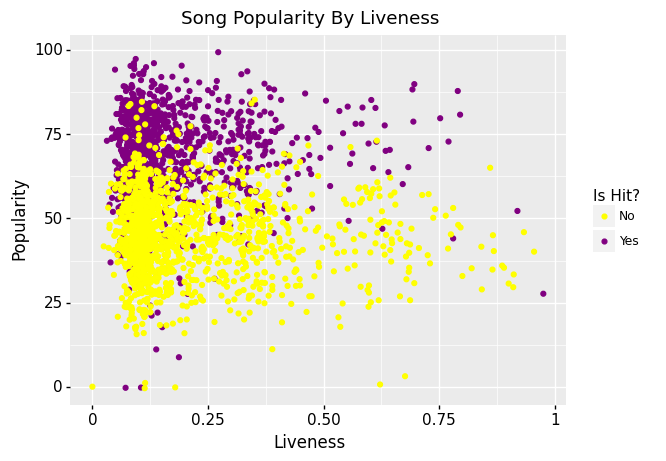

<ggplot: (139656603950)>

In [397]:
(
    fullSongs >>
    select(X.liveness, X.valence, X.popularity, X.isHit) >>
    ggplot() +
    geom_point(aes(x = "liveness", y = "popularity", color = "factor(isHit)"), position = "jitter") +
    labs(
        x = "Liveness",
        y = "Popularity",
        title = "Song Popularity By Liveness",
        color = "Is Hit?"
    ) +
#     theme(axis_text_x = element_text(rotation = 90)) +
    scale_color_manual(labels = ["No", "Yes"],
                      values = ["yellow", "Purple"]) +
    theme(axis_text = element_text(color = "black", size = 11)) +
    theme(axis_title = element_text(color = "black", size = 12))
#     theme(figure_size = (30, 10))
)

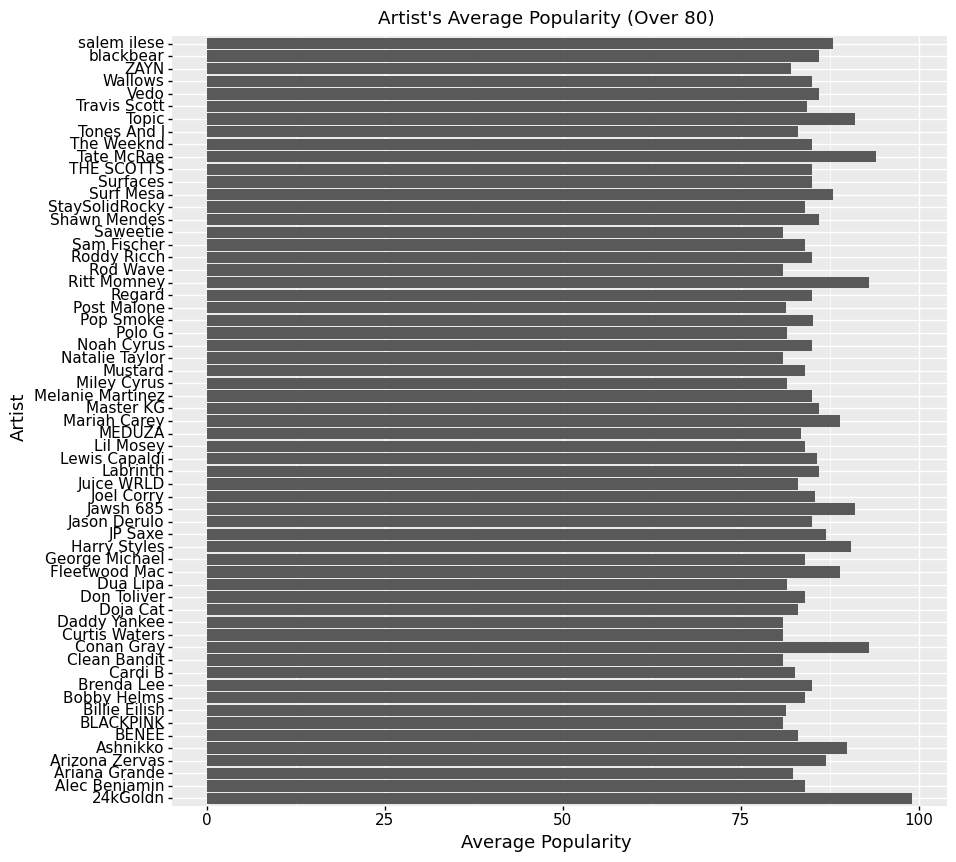

<ggplot: (139656279080)>

In [267]:
(
    X_train >>
    group_by(X.artist) >>
    summarize(meanPop = X.popularity.mean()) >>
    arrange(X.meanPop, ascending = True) >>
    mask(X.meanPop > 80) >>
    ggplot() +
    geom_bar(aes(x = "artist", y = "meanPop"), stat = "identity") +
    labs(
        x = "Artist",
        y = "Average Popularity",
        title = "Artist's Average Popularity (Over 80)"
    ) +
    coord_flip() + 
    theme(axis_text = element_text(color = "black", size = 11)) +
    theme(axis_title = element_text(color = "black", size = 13)) +
    theme(figure_size = (10, 10))
)

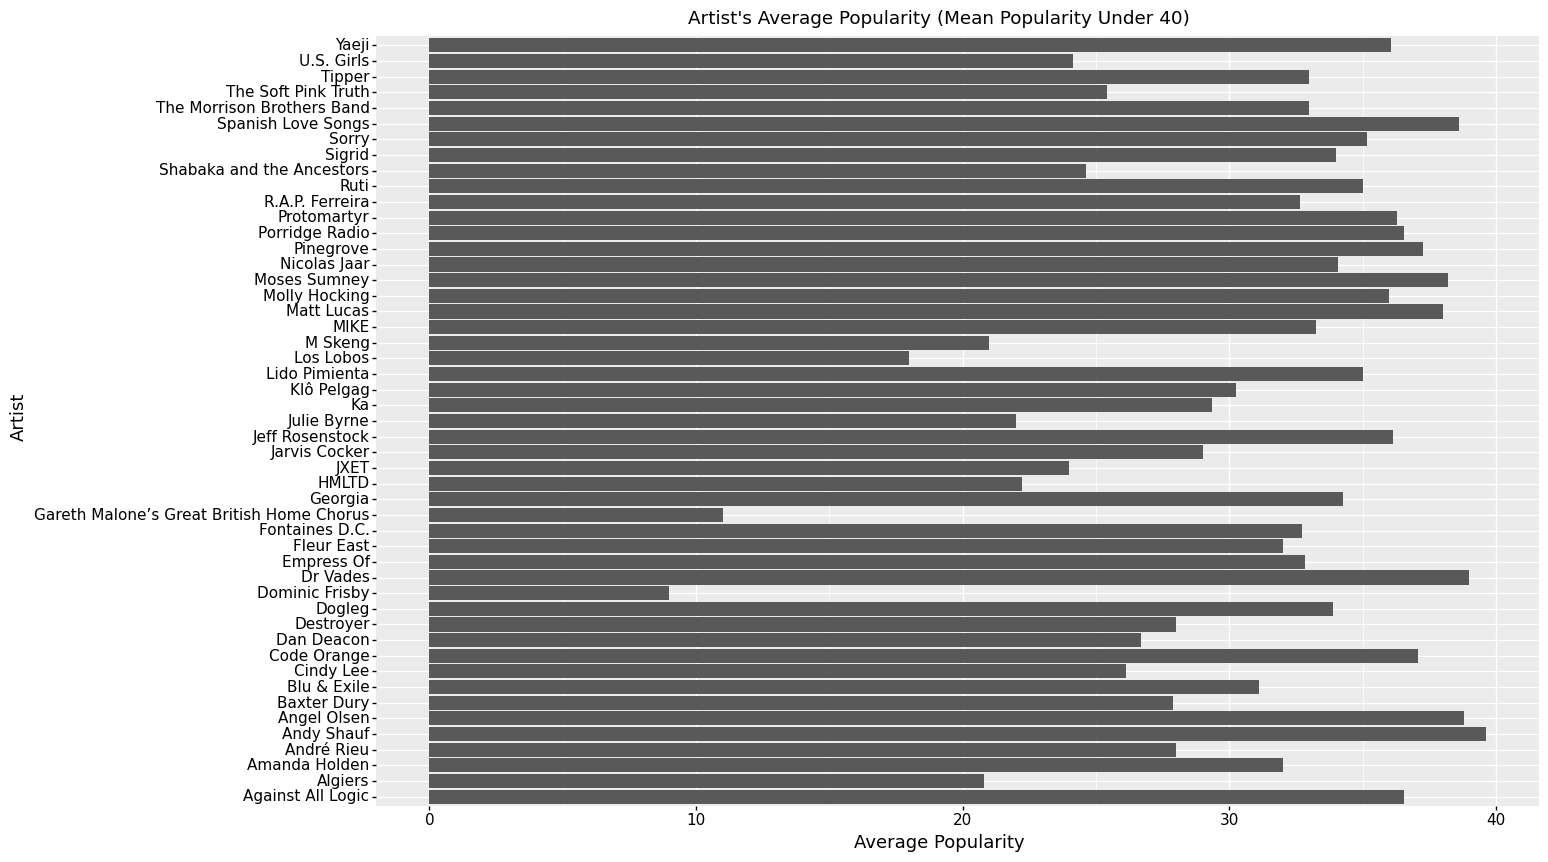

<ggplot: (139658072676)>

In [384]:
(
    fullSongs >>
    group_by(X.artist) >>
    summarize(meanPop = X.popularity.mean()) >>
    arrange(X.meanPop, ascending = True) >>
    mask(X.meanPop < 40) >>
    ggplot() +
    geom_bar(aes(x = "artist", y = "meanPop"), stat = "identity") +
    labs(
        x = "Artist",
        y = "Average Popularity",
        title = "Artist's Average Popularity (Mean Popularity Under 40)"
    ) +
    coord_flip() + 
    theme(axis_text = element_text(color = "black", size = 11)) +
    theme(axis_title = element_text(color = "black", size = 13)) +
    theme(figure_size = (15, 10))
)

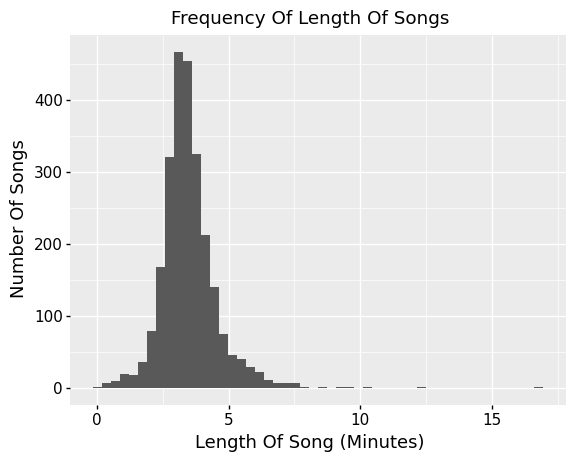

<ggplot: (139656352850)>

In [339]:
(
    fullSongs >>
    
    mutate(duration_sec = X.duration_ms/1000) >>
    mutate(duration_min = X.duration_sec/60) >>
    ggplot() +
    geom_histogram(aes(x = "duration_min"), bins = 50) +
    labs(
        x = "Length Of Song (Minutes)",
        y = "Number Of Songs",
        title = "Frequency Of Length Of Songs"
    ) +
    theme(axis_text = element_text(color = "black", size = 11)) +
    theme(axis_title = element_text(color = "black", size = 13)) 
)

In [376]:
meanMins = (fullSongs >>
 group_by(X.isHit) >>
 mutate(duration_min = X.duration_ms/(1000*60)) >>
 summarize(meanMin = X.duration_min.mean())
)
meanMins


,isHit,meanMin
0,0.0,3.578643
1,1.0,3.330188


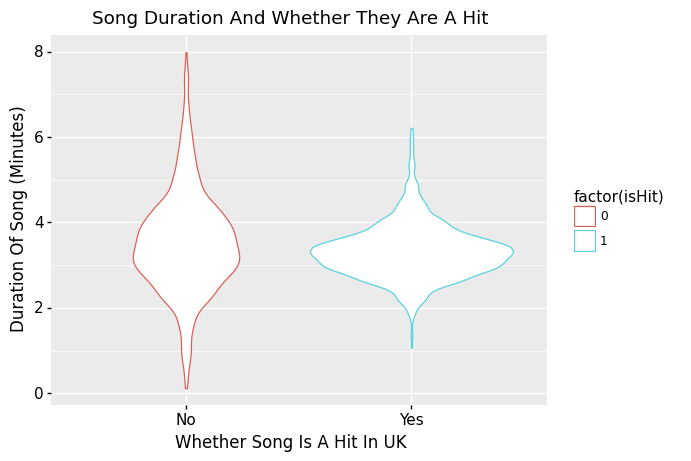

<ggplot: (139664923519)>

In [383]:


(
    fullSongs >>
    mutate(duration_min = X.duration_ms/(1000*60)) >>
    mask(X.duration_min <= 8) >>
    ggplot() +
    geom_violin(aes(x = "factor(isHit)", y = "duration_min", color = "factor(isHit)")) +
    labs(
        x = "Whether Song Is A Hit In UK",
        y = "Duration Of Song (Minutes)",
        title = "Song Duration And Whether They Are A Hit"
    ) +
#     geom_hline(yintercept = meanMins["meanMin"][0], color = "yellow") +
#     geom_text(label = meanMins["meanMin"][0], position = "stack") +
#     geom_hline(yintercept = meanMins["meanMin"][1], color = "purple") +
    theme(axis_title = element_text(color = "black", size = 12)) +
    theme(axis_text = element_text(color = "black", size = 11)) +
    scale_x_discrete(labels = ["No", "Yes"])
)

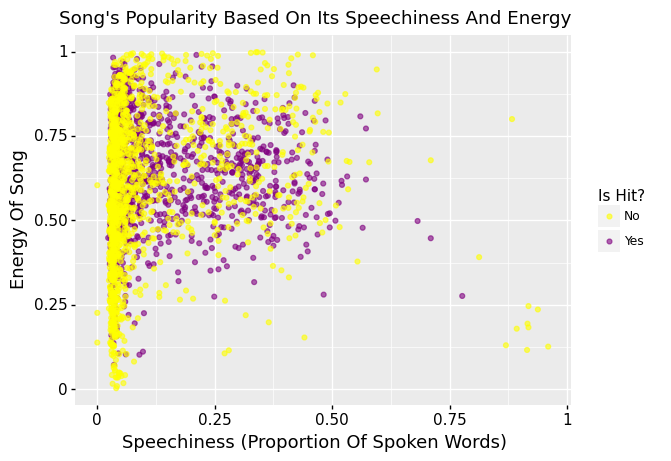

<ggplot: (139662877847)>

In [352]:
(
    fullSongs >>
    ggplot() +
    geom_point(aes(x = "speechiness", y = "energy", color = "factor(isHit)"), alpha = 0.6, position = "jitter") +
    labs(
        x = "Speechiness (Proportion Of Spoken Words)",
        y = "Energy Of Song",
        title = "Song's Popularity Based On Its Speechiness And Energy",
        color = "Is Hit?"
    ) +
    scale_color_manual(values = ["yellow", "purple"],
                      labels = ["No", "Yes"]) +
    theme(axis_title = element_text(color = "black", size = 13)) +
    theme(axis_text = element_text(color = "black", size = 11))
)

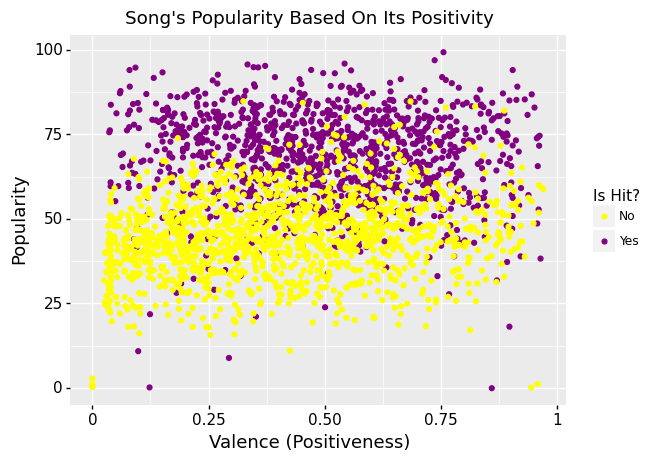

<ggplot: (139664960525)>

In [307]:
(
    fullSongs >>
    select(X.valence, X.popularity, X.duration_ms, X.isHit) >>
    ggplot() +
    geom_point(aes(x = "valence", y = "popularity", color = ("factor(isHit)")), position = "jitter") +
    labs(
        x = "Valence (Positiveness)",
        y = "Popularity",
        title = "Song's Popularity Based On Its Positivity",
        color = "Is Hit?"
    ) +
    scale_color_manual(values = ["yellow", "purple"],
                      labels = ["No", "Yes"]) +
    theme(axis_title = element_text(color = "black", size = 13)) +
    theme(axis_text = element_text(color = "black", size = 11))
)

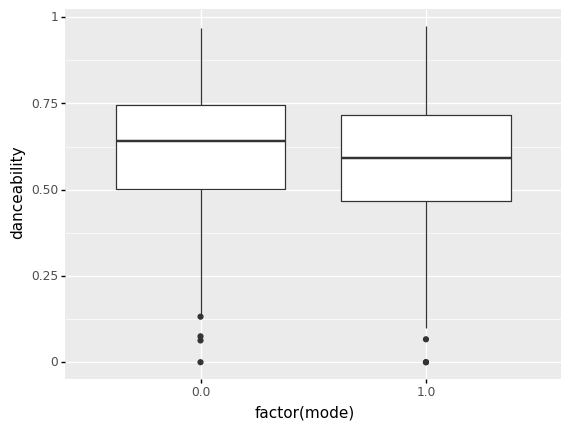

<ggplot: (139656718602)>

In [341]:
(
    fullSongs >>
#     group_by(X.mode) >>
    group_by("mode") >>
    #select("mode", X.tempo, X.popularity, X.duration_ms, X.isHit) >>
    ggplot() +
    geom_boxplot(aes(x = "factor(mode)", y = "danceability"))
)

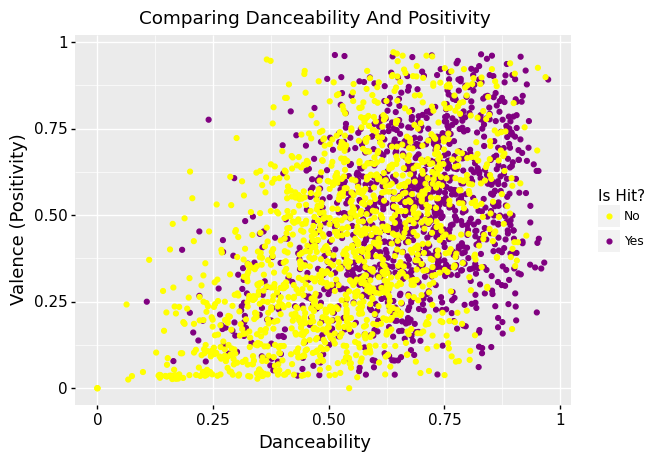

<ggplot: (139656345016)>

In [345]:
(
    fullSongs >>
    ggplot() +
    geom_point(aes(x = "danceability", y = "valence", color = "factor(isHit)"), position = "jitter") +
    labs(
        x = "Danceability",
        y = "Valence (Positivity)",
        title = "Comparing Danceability And Positivity",
        color = "Is Hit?"
    ) +
    scale_color_manual(values = ["yellow", "purple"],
                      labels = ["No", "Yes"]) +
    theme(axis_title = element_text(color = "black", size = 13)) +
    theme(axis_text = element_text(color = "black", size = 11))
)

# Modelling

In [ ]:
## TODO:
## IDEA: make key into a dummy variable. Do it on fullSongs.copy()
## And then you can split the data.

In [398]:
Y = fullSongs.isHit
XData = (fullSongs >> 
         select(columns_to("isHit", inclusive = False))
        )
    

X_train, X_test, Y_train, Y_test = train_test_split(XData, Y, test_size=0.25, random_state = 420)

In [ ]:
d = train_X.copy()
d = train_X.select_dtypes(include= "int64").melt()
(
    ggplot(d,aes(x="value")) +
    geom_histogram() +
    facet_wrap("variable",scales="free") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
)

In [293]:
# (0) Split the data 
train_X, test_X, train_Y, test_Y = train_test_split(X,y, test_size=.25, random_state =202011)

# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
# min-max scale these 3 variables: Records, Job, Debt, Income, Home
# we'll see how to preprocess categorical variables next week: 11/18/2020 November 18
# 
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), 
                ["partime", "Records", "Income", "Assets", "Amount", "Expenses"])])


# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
# spawn a preprocess object
# leave model as blank...cuz we're gonna spawn one eventually...
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])
# fun fact: we don't even have to use the word "model" We could use a random name, like "duck"
# or "P'Dean"

# but please, "model" is a place_holder.
# You change the woird "model" into "P'Dean", you'll have to write "P'Dean"

# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    
    # TODO: IDEA: Naive Bayes Classifier
    
    
    
    {'model' : [GaussianNB()]},
    
    # Linear Model
    #{'model' : [LM()]},
    # Actually, don't use a linear model. Because we are classifying, 
    # Not regressing (numeric predictions)
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30],
     'model__leaf_size' : [40]}, # Notice the double underscore after model
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,4,5]},
    
    # The Bagging decision tree model 
    #{'model': [Bag()]},
    
    # Random forest (Classifier) with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3, 4],
     'model__n_estimators':[500,1000,1500]},
]


# (5) Put it all together in the grid search
# search_space was the tuing parameters or something
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_X,train_Y)

Index(['album', 'artist', 'trackNumber', 'id', 'name', 'uri', 'release_date',
       'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity',
       'speechiness', 'tempo', 'time_signature', 'valence', 'isHit'],
      dtype='object')

In [97]:
artist = "EDEN"
album = "no future"
query = toQuery(artist, album)
album_uri = sp.search(query, type = "album")["albums"]["items"][0]["uri"]

trackIDSet = getTrackIDs(album_uri)
trackIDList = toList(trackIDSet)

# loop over track ids 
tracks = []
for i in range(len(trackIDList)):
    time.sleep(.5)
    track = getTrackFeaturesList(trackIDList[i])
    
    # for isHit
    track.append(0)
    tracks.append(track)

# create dataset
otherSongs = pd.DataFrame(tracks, columns = ['album', 'artist', 'trackNumber', "id", "name", "uri", 'release_date', "acousticness",
                                      'danceability', "duration_ms", 'energy', "explicit", 'instrumentalness', "key", 
                                     'liveness', 'loudness', "mode", "popularity", 'speechiness', 'tempo', 'time_signature',
                                    "valence", "isHit"])
otherSongs.to_csv("otherSongs.csv", sep = ',')


{'0xQp7EzyIOypjxMdJD2KTr',
 '13nqSnXz9VOVEZT5gwCRgf',
 '1L26DQEUyv3IUpg4YvZa8z',
 '2EDNVyNa7krZFyb7Wlou0A',
 '2RPbRx7ySrYfq62yNKPvQV',
 '2nBwC0sBIO4xiZEsOCRb7N',
 '2vec1SirAf9NVU5YFpYKWo',
 '33TqEVMeD9FUfyL2V5kDW7',
 '3e7pEEevOCe5rHNvYZM5eW',
 '3xsqVzOwQIF3cx1BUOXfwr',
 '4IgjPOtebV0KG5MK7WHW0M',
 '4laOJWnkJHMEvkR8LFohgQ',
 '51WcF4bMAAhJTUhLMHl6Dh',
 '5DsmK9Xx16mjpPDjSU4YhQ',
 '5TRvbTPZHYI1PoHPyKF4CY',
 '6EGKCz3dehJc1NAhrvlWYm',
 '6k07poaGGgQWBYbEaaSV2n',
 '702GncAZXiEArIWBgaPJDi',
 '7aJROEYeIYJrA81TPEdyBz'}

In [279]:





idSet = set()
idList = []
# List of other playlists that came out in 2020 and 2019.
playlistLists = [#"spotify:playlist:21DNCmLznxWN3CkypQnR8G","spotify:playlist:4IdtgLeEyKlwb6PyrwguP0",
                
                    # The Cribs, album = Night Network
                 "spotify:album:5GoKGpW3CAPfMvdegiCHAp",
    
                # Artist = Nothing, album = The Great Dismall
                 "spotify:album:0LKwC9p0PLomstKm9Y0nt3",
                 
                 # Artist = Nothing, album = Spirit Of The Stairs
                 "spotify:album:1FhTscmvDVVPQhTipBqsxF",
                 # Artist = Puscifer, album = Existential Reckoning
                 "spotify:album:4eYJzO460ZGaEFNJ4YCizR",
                 
                 # Artist = Ane Brun, album = After The Great Storm
                 "spotify:album:4CsoXWnATm35jRUCemZxYZ"
                 
                 # Artist = Phoenix Ash, album = Voices
                 "spotify:album:7F7TalMiSETIKgaES289JJ",
                 
                # Artist = Boy Sompob, album = The Luckiest Boy And The Luckiest Fans(Live)
                "spotify:album:2282fQEMBPsB90KHB1khTY",
    
                # Artist = "SEVENTEEN", album = Ode
                "spotify:album:4btxaakgIaE1AkXqpReLwd",
    
                # Artist = Joni Mitchell, album = Joni Mitchell Archives, Vol. 1: The Early Years 1963-1967 [Box Set]
                "spotify:album:5YtEGR5G9awoXLfInVhZxC",
    
                # Artist = Dizzee Rascal, album = E3 AF
                "spotify:album:78prqMEFoQ6AKyDN8DEtqI",
    
                # Artist =  Catherine Anne Davies, album = In Memory Of My Feelings
                 "spotify:album:2OyZsiog3RglvsNnZ6825C",
    
    # Artist = Emmy The Great, Album = April 月音
    "spotify:album:4UKkCTAvqBAWVBnakgxmo2",
    
    # Artist = Sault, album = Untitled (Rise)
    "spotify:album:0K8jX7CLwxJaML5iXdxveF",
    
    # Artist = TWICE, album = Eyes Wide Open
    "spotify:album:33jypnU7WULxPaVrjj4RXH",
    
    # Artist = We The Kings, album = Season Greetings from the Sandbar
    "spotify:album:6U6NL7d3rGZPe2Zetma4oO",
    
    # Artist = Cut Worms, album = Nobody Lives Here Anymore
    "spotify:album:1GvCetmOWQbkkmG6fpXWgu",
    
    # Artist = Deep Sea Diver, album = Impossible Weight
    "spotify:album:7CzuB7MJ8s2V7dzXP0kXrN",
    
    # Artist = Black Thought, album = Streams Of Thought
    "spotify:album:2LEEg9PQsJqQuhBU0poSrd",
    
    # Artist  = Future Islands, album = As Long As You Are
    "spotify:album:5VRzYNGWztoQLcAkCeUUpE",
    
    # Artist = METZ, album = Atlas Landing
    "spotify:album:2LisIakag43SaJ7d04l71I",
    
    # Artist = Mary Lattimore, album = Silver Ladders
    "spotify:album:5ROFj16TsmnCUd5YtiVDU3",
    
    # Artist = Mary Lattimore, album = AVL
    "spotify:album:2Jdxjq5mSz3XdMg0FhphtH",
    
    # Artist = Travis Scott, album = Jackboys
    "spotify:album:1Sf8GsXG32t0jNrX11xqWx",
    
    # artist = Touché Amoré, album = Lament
    "spotify:album:6fA79mAHNeBhaUnuWBADwc",
    
    # Artist = Headie One, album = Edna
    "spotify:album:0fq4uzIIA44Bkw0fCQ5KAU",
    
    # Artist = Headie One, album = GANG
    "spotify:album:5971dUyMLcsZa7IBioI7lP",
    
    # Artist = Headie One, album = Music X Road
    "spotify:album:6J41exElcUa6rK5SJmjV6S",
    
    # Artist = The All American Rejects, album = Rejects Faves
    "spotify:album:5Gvggd8POGWHwOdFsiI0QJ",
    
    # Artist = Blink 187, album = NINE
    "spotify:album:4gARZz9eV7zbGbtOjhVTPF",
    
    # Artist = Sum 41, album = Order In Decline
    "spotify:album:7j11BWRSLFBFUVR4EPG6WD",
    
    # Fall Out Boy, album = Believers Never Die (Volume Two)
    "spotify:album:2MlgtDuxXXz8c8Toc9kKTd",
    
    # Artist =  Bahamas, album = Sad Hunk
    "spotify:album:0vWNWn7PcEotOycEtBC7br",
    
    # Artist = The Budos Band, album = Long In The Tooth
    "spotify:album:5WDvttBOfFtyNTnke69UCJ",
    
    # Artist = The Budos Band, album = V
    "spotify:album:21fq2HanTNvaBj5wbdfSqH",
    
    # Artist = Slow Pulp, album = Moveys
    "spotify:album:3RVAiBjIsu9OSYPWo6dcDq",
    
    
    # Artist = The Replacements, album = Pleased To Meet Me
    "spotify:album:7aBqHtuRwfwNXcllqmvZuw"
    
    # Artist = MAMAMOO, album = reality in BLACK
    "spotify:album:7CucpzwxAZ6kHmctI9eo4X",
    
    # Artist = MAMAMOO, album = 4colors
    "spotify:album:232T6PgapFXcufLzzRJU8u",
    
    # Artist = BLACKPINK, album = THE ALBUM
    "spotify:album:71O60S5gIJSIAhdnrDIh3N",
    
    # Nu'Est, album = The Nocturne
    "spotify:album:5j8qRyyqFwXkIH7boJ6m9N",
    
    # Artist = Garcia Peoples, album = Nightcap at Wit's End
    "spotify:album:2XF9HRQ40ZUsil8GJ56WAS",
    
    # Artist = Andy Bell, album = The View From Halfway Down
    "spotify:album:2Xt22gwrtjMKQQAayKbw4R",
    
    # Artist = John Lennon, album = Gimme Some Truth
    "spotify:album:0K4DpGioXU2rkHJEXoarWm",
    
    # Artist = Yo La Tengo, album = Sleepless Night
    "spotify:album:0PjdFeBOBimMQg7oj8nmn6",
    
    # Artist = Cubers, album = MAJOR OF CUBERS
    "spotify:album:7LfhaR3hTcyZL9z2JGTEH1",
    
    # Artist = The Doors, album = Morrison Hotel
    "spotify:album:44rCgxcyCycEQybZn793dz",
    
    # Artist = The Doors, album = The Soft Parade
    "spotify:album:0MuuO7q58HbGU3qUjICucE",
    
    # Artist = Ustad Saami, album = Pakistan is for the Peaceful
    "spotify:album:2dn4MYGo6UNaw4vXpQfgKp",
    
     # Artist = Ustad Saami, album = God Is Not A Terrorist
    "spotify:album:5fzug7OI3gZea4RcOBRwS0",
    
    # Artist = Róisín Murphy, album = Roisin Machine
    "spotify:album:5WpDQt6EbpzXbqo9g9P0L6",
    
    # Artist = Jónsi, album = Shiver
    "spotify:album:6toqeyCvwGd0G4Lr1TPQCZ",
    
    # Artist = The Nude Party, album = Midnight Manor
    "spotify:album:3OePCCzmF2nfuEJWQ521eQ"
    
    # Artist = Working Men's Club, album = Working Men's Club
    "spotify:album:4Uzll2pB5SnmC0rulgDHyB",
    
    # Artist = Shamir, album = Shamir
    "spotify:album:6rACMQ2WTjZ8z8kpTC6sFu",
    
    # Artist = Shamir, album = Cataclysm
    "spotify:album:6AlQCCCLAt0bALqPv4Qamz",
    
    # Dawes, album = Good Luck With Whatever
    "spotify:album:3esEgXmUs1zjBVqijbZ6RQ",
    
    # Death Valley Girls, album = Under The Spell Of Joy
    "spotify:album:2cAtSN53M8tOlV8iejBRiS",
    
    # Billkin, Skyline
    "spotify:album:0BRS9EeGy9IHobfnnrreUX",
    
    # Artist = Melanie C, album = Melanie C
    "spotify:album:7owRAI8xguTpim2jdn0Chg",
    
    # Artist = Mariah Carey, album = The Rarities
    "spotify:album:0v1DRRYBXYg1uVN1CIsyy0"
    
    # Artist = The Jaded Hearts Club, album = You've ALways Been Here
    "spotify:album:4bLyKjPIhAijzz3JLUBJQn",
    
    # Artist = The Jaded Hearts Club, album = I Put A Spell On You
    "spotify:album:3OFJG5DNFLUGArlIGd4PtN",
    
    # Artist = Bartees Strange, album = Live Forever
    "spotify:album:4Lu520UvMf7lJccCnKw3hJ",
    
    # Artist = Westside Gunn, album = Who Made The Sunshine
    "spotify:album:6NrUdvJpIEyaBg5zZSOoV4",
    
    # Artist = Westside Gunn, album = Flygod Is An Awesome God 2
    "spotify:album:2juInocve2NIFoNCX1cwWH",
    
    # Artist = 21 Savage, album = Savage Mode II
    "spotify:album:263anqt2ayA25jSEXfs0i1"
    
    # Artist = Corey Taylor, album = CMFT
    "spotify:album:2zXb31jcD4thGh78UbcXzv",
    
    # Artist = Eartheater, album = Phoenix: Flames Are Dew Upon My Body
    "spotify:album:7sc80uUN9dNdVB325D7XZ5",
    
    # Artist = Drive-By Truckers, album = The New OK
    "spotify:album:3gaivd3LY4Uy7nTBj642OS",
    
    # Artist = LANY, album = Mama's Boy
    "spotify:album:6tmSIFaEjxAtuYwPq9FaFP",
    
    # Artist = DevilDriver, album = Dealing With Demons
    "spotify:album:4e8vGr6fmuqT5XHnOJn4AA",
    
    # Artist = Laura Jane Grace, album = Stay Alive
    "spotify:album:2BBk7kjQwYdV0UgeYx0JYK",
    
    # Artist = Idles, album = Ultra Mono
    "spotify:album:0ojQHzflxMs6SfvBBkRKt6",
    
    # Artist = Idles, album = The Beautiful Thing
    "spotify:album:0molHoHmFmZKcNpiEKBCRK",
    
    # Artist = Sufjan Stevens, album = The Ascension
    "spotify:album:1tYHjJ50WowcNvDTLdf6Wo",
    
    # Artist = Bob Mould, album = Blue Hearts
    "spotify:album:13ioe4Gi99cfMH1glnKOUN",
    
    # Artrist = Yellow Days, album = Day in a Yellow beat
    "spotify:album:6Cn3JpoA3LIrISLDH2gYmJ",
    
    # Artist = Thurston Moore, album = By The Fire
    "spotify:album:4BDskQQhVpsxax7WGOUJQQ",
    
    
    # Artist = Deftones, album = Ohms
    "spotify:album:0VEFy5MsBiq0u2lWL0OwOd",
    
    # Artist = Will Butler, album = Generations
    "spotify:album:4M6ypRmlMvKBynpS3mVnZ8",
    
    # Artist = Bowling For Soup, album = A Nice Night For An Evening, Vol 1
    "spotify:album:2oP3ebFU7Mo7J9ks50OMuc",
    # Artist = Bowling For Soup, album = A Nice Night For An Evening, Vol 2
    "spotify:album:4KbFE3ly5F6BsQIPL0Olvp",
    
    # Artist = A Certain Ratio, album = ACR Loco
    "spotify:album:0ir4mtY7qNrXyLzQ00dF63",
    
    "spotify:album:2sJEf6m0APxS4yRQAgOons",
    
    # Artist = Public Enemy, album = What you Gonna DO When The grid goes down
    "spotify:album:5guHpNnWHHU1CyvpZCayee",
        # album = Fight The Power
    "spotify:album:384HCDQ0k9Wxw0pgVVU77I",
    
    # Artist = Sad13, album = Haunted Painting
    "spotify:album:7c5uY5dlx4N2AIUEbb2wC5"
    
    # Artist = Surfer Blood, album = Carefree Theatre
    "spotify:album:4yPh47GCceinLEY4SrQAG3"
    # album = Astro Coast (10 Year Anniversary)
    "spotify:album:7b3FKbzib7yFb77QpO4A1Q"
    
    # Artist = Marie Davidson, album = Renegade Breakdown
    "spotify:album:0ttippsmFz8st2fYSNcTOS",
    
    # Artist = Relient K, album = Live
    "spotify:album:5HdJHVOP84JZhiCUxYbghp",
    
    # Artist = Prince, album = Sign O' The Times
    "spotify:album:2Uv3zad993qvBkrOcIqdgq"
    
    # Artist = Sylvan Esso, album = Free Love
    "spotify:album:2KAPJ40On8JY1Yt64JJgTk",
    
    # album = WITH
    "spotify:album:68ClkAMsCDyx2lQMsnbY55",
    
    # artist = Lou Reed, album = New York
    "spotify:album:3qrRrzn51B9wdZVLW8owTP",
    
    # Artist = Yves Jarvis, album = Sundry Rock Song Stock
    "spotify:album:7N3gPiUIMhiDEaB3SQtEIy",
    # The Same But By Different Means
    "spotify:album:4StHE1Ec8V0I1QogfTB2fA",
    
    # Artist = Stray Kids, album = All In
    "spotify:album:06EHg8PHtDhbZMpE0jmhEn",
    # In Life
    "spotify:album:1fOJ6SHLXOLnsuuwiLyzft",
    
    # Go Live
    "spotify:album:7B3Rmyws1KcAxQfYPoInEZ",
    
    "spotify:album:5tCOElmd7wcBGbt1f8bFYR",
    "spotify:album:162XZSDZpr559n4iyLy8m5",
    
    # Fluke Natouch
    "spotify:album:5Iy0SBWPCX9ciPagXPPHLF",
    
    # Artist = Anna von Hausswolff, album - All Thoughts Fly
    "spotify:album:4ZsKcq417wTfTHtYzP7Sbf",
    
    # Artist = Hen Ogledd, album = Free Humans
    "spotify:album:7oIXolIsJGvF7QI4FZAekK",
    
    # Artist = Diana Krall, album = This Dream Of You
    "spotify:album:2axVAnC2sE98xigU2BV1TY",
    
    # Artist = Blitzen Trapper, album = Holy Smokes Futujre Jokes
    "spotify:album:10D5ke3EYdoFD89zQZjjVc",
    
    # Teresa Tung
    "spotify:album:6sG5IWnWKkUR60JPvMipKu",
    "spotify:album:2tj9SbzhZyoaNblEZhJiaT",
    
    # Artist = Lydia Loveless, album = Daughter
    "spotify:album:1o8GJAoDGE31niMCK1y7uC",
    
    # Artist = Tim Heidecker, album = Fear Of Death
    "spotify:album:04EdoR8zMbu7QfDEBHoA0X",
    
    
    # What the broken heart do
    "spotify:album:573YzEr3P3O5XkJEZWmOtP",
    
    # artist = Action Bronson, album = Only Fpr Doolphin
    "spotify:album:1ZbgQbpmCbLX2RTYSAIG6k",
    
    # Lamb Over Rice
    "spotify:album:3BPX4x5EQOd9vzpPC2rMrm",
    
    # Artist = Fleet Foxes, album = Shore
    "spotify:album:0lmjCPEcec2k6L7ysNIcd3",
    
    # Artist = Osees, album = Metamorphosed
    "spotify:album:5bw79tNjZS73fZyCvl2irH",
    # Levitation SEssions (Live)
    "spotify:album:57MuWnA4Sns5ZfWnH03fQr",
    # Protean Threat
    "spotify:album:16l3FJwjZooUHbU37sdeeI",
    
    # Artist= Sarah Davachi, album = Cantus Descant
    "spotify:album:6QQlw7AOPEaL3ot8V211cV",
    
    # Artist= Deradoorian, album = Find The Sun
    "spotify:album:6aejLD0bE9xQvpFva2zDEI",
    
    # Artist = Gus Dapperton, album = orca
    "spotify:album:1D8cnABQfjvfQC2Cdk889m"
                ]
for uri in playlistLists:
    playlistURI = uri
    user = playlistID.split(":")[2]
    ids = getTrackIDs(playlistURI)
    #print(len(ids))
    idSet.update(ids)
idList = toList(idSet)
print(len(idList))

1484


In [280]:
# loop over track ids 
tracks = []
for i in range(len(idList)):
    time.sleep(.5)
    track = getTrackFeaturesList(idList[i])
    
    # for isHit
    track.append(0)
    tracks.append(track)

# create dataset
otherSongs = pd.DataFrame(tracks, columns = ['album', 'artist', 'trackNumber', "id", "name", "uri", 'release_date', "acousticness",
                                      'danceability', "duration_ms", 'energy', "explicit", 'instrumentalness', "key", 
                                     'liveness', 'loudness', "mode", "popularity", 'speechiness', 'tempo', 'time_signature',
                                    "valence", "isHit"])
otherSongs.to_csv("otherSongs.csv", sep = ',')



In [281]:
otherSongs

# (dfNoNA.merge(df, how = "left", on = "id") >>
#  filter_by(X.isHit.isna()) >>
#  select(X.name_x, X.isHit)
# )

,album,artist,trackNumber,id,name,uri,release_date,acousticness,danceability,duration_ms,...,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence,isHit
0,Joni Mitchell Archives – Vol. 1: The Early Yea...,Joni Mitchell,23,7JnIimk8J3H1o828YLgZJT,"Night In The City - Live at The 2nd Fret, Phil...",spotify:track:7JnIimk8J3H1o828YLgZJT,2020-10-30,0.879000,0.367,213840,...,11,0.730,-12.420,0,24,0.0568,172.867,3,0.284,0
1,Generations,Will Butler,7,5ScoiFcPXDEN1O4U2fbpcX,Hard Times,spotify:track:5ScoiFcPXDEN1O4U2fbpcX,2020-09-25,0.104000,0.787,233693,...,7,0.363,-9.534,1,34,0.0877,125.109,4,0.431,0
2,reality in BLACK,MAMAMOO,1,6oS5qBlnci7unQjdLiok41,Destiny,spotify:track:6oS5qBlnci7unQjdLiok41,2019-11-14,0.473000,0.562,247600,...,9,0.239,-4.647,1,58,0.1330,131.917,4,0.235,0
3,Teresa Teng 30 Hits,Teresa Teng,5,1ZDhKeifk8mJTZ4Z99HOix,台灣小調,spotify:track:1ZDhKeifk8mJTZ4Z99HOix,2020-05-19,0.627000,0.488,129593,...,7,0.182,-10.536,0,16,0.0539,129.540,4,0.868,0
4,Teresa Teng 30 Hits,Teresa Teng,15,1R3xD2IxF4LmMcY6gbIq0j,心疼的小寶寶,spotify:track:1R3xD2IxF4LmMcY6gbIq0j,2020-05-19,0.924000,0.468,135967,...,3,0.208,-4.807,1,12,0.0426,125.156,4,0.868,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1479,The Luckiest Boy And The Luckiest Fans (Live),Boy Sompob,2,2odAd626HMTHYOnChqml7R,ขอ - Live,spotify:track:2odAd626HMTHYOnChqml7R,2020-04-16,0.590000,0.633,232000,...,9,0.780,-14.158,1,12,0.0807,110.039,4,0.531,0
1480,IN LIFE,Stray Kids,7,2OU8SjA9462FhrfqssKJJn,"Wow (Lee Know, Hyunjin, Felix)",spotify:track:2OU8SjA9462FhrfqssKJJn,2020-09-14,0.003700,0.731,193811,...,8,0.068,-5.955,0,66,0.0678,127.921,4,0.534,0
1481,acr:box,A Certain Ratio,1,5Xa4guJtODCsWBYxrq2PAY,All Night Party,spotify:track:5Xa4guJtODCsWBYxrq2PAY,2019-05-03,0.000029,0.176,196546,...,3,0.309,-12.142,1,8,0.0462,79.375,4,0.189,0
1482,Under the Spell of Joy,Death Valley Girls,2,1JtzHKdzD9kdu6Sly6Gcld,Hold My Hand,spotify:track:1JtzHKdzD9kdu6Sly6Gcld,2020-10-02,0.000106,0.460,161746,...,2,0.366,-4.737,1,33,0.0505,131.090,4,0.595,0


## Grabbing The Artist Name From A Single TitleArtist Row From UMD

In [216]:
titleArtistRow = "What You Know Bout Love POP SMOKE"

def getRow(titleArtistRow):
    
    results = sp.search(titleArtistRow)

    # artist name
    artist = results["tracks"]["items"][0]["artists"][0]["name"]
    #artistID = results["tracks"]["items"][0]["artists"][0]["id"]

    # Album Name
    album = results["tracks"]["items"][0]["album"]["name"]

    # track name
    track = results["tracks"]["items"][0]["name"]
    uri = results["tracks"]["items"][0]["uri"]
    # track ID
    trackID = results["tracks"]["items"][0]["id"]
    isHit = True
    audioFeatureDict = sp.audio_features(trackID)[0]
    acousticness = audioFeatureDict["acousticness"]
    danceability = audioFeatureDict["danceability"]
    duration_ms = audioFeatureDict["duration_ms"]
    energy = audioFeatureDict["energy"]

    # Explicit
    # audioFeatureDict["explicit"]
    explicit = sp.track(trackID)["explicit"]
    instrumentalness = audioFeatureDict["instrumentalness"]
    key = audioFeatureDict["key"]
    liveness = audioFeatureDict["liveness"]
    loudness = audioFeatureDict["loudness"]
    mode = audioFeatureDict["mode"]
    popularity = sp.track(trackID)["popularity"]
    speechiness = audioFeatureDict["speechiness"]
    tempo = audioFeatureDict["tempo"]
    timeSignature = audioFeatureDict["time_signature"]
    valence = audioFeatureDict["valence"]
